# ANÁLISIS MULTIVARIANTE: Global poverty and inequality dataset

El objetivo de este trabajo es, a partir de un conjunto de datos con información acerca de la pobreza y la desigualdad de diferentes países a lo largo del mundo durante diversos años, realizar una reducción de la dimensionalidad para posteriormente intentar encontrar mediante métodos de agrupación o *clustering* regiones similares. Así pues, ya que disponemos de datos acerca de países, los cuales están estrictamente delimitados, haremos uso de información espacial para perfeccionar los resultados.



### Tabla de Contenidos: <a class="anchor" id="index"></a>

<div class="alert" style="margin-top: 20px">

1. [Preparación del entorno de trabajo](#seccion_1)<br>

2. [Análisis descriptivo por subrgupos y transformación de variables](#seccion_2)<br>

3. [Análisis e imputación de datos perdidos](#seccion_3)<br>

4. [Análisis de correlaciones y reducción de la dimensionalidad](#seccion_4)<br>

5. [Análisis cluster](#seccion_5)<br>

6. [Análisis geoestadístico](#seccion_6)<br>

7. [Referencias](#seccion_6)<br>

</div>


### 1. Preparación del entorno de trabajo <a class="anchor" id="seccion_1"></a>



In [204]:
import pandas as pd
import geopandas as gpd
import geodatasets
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy.stats import zscore, f, boxcox, skew, shapiro

import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.exceptions import ConvergenceWarning

from continents import continent_dict 
from handleData import handleData

In [205]:
# Load the  dataset
file_name = 'pip_dataset.csv'
data = pd.read_csv( file_name)
data['continent'] = data['country'].map(continent_dict) # create column continet
data = data[['country', 'continent'] + [col for col in data.columns if col not in ['country', 'continent']]]
data.head()

country continent  year reporting_level welfare_type  ppp_version  \
0  Albania    Europe  1996        national  consumption         2011   
1  Albania    Europe  2002        national  consumption         2011   
2  Albania    Europe  2005        national  consumption         2011   
3  Albania    Europe  2008        national  consumption         2011   
4  Albania    Europe  2012        national  consumption         2011   

   survey_year  survey_comparability  headcount_ratio_international_povline  \
0       1996.0                   0.0                               0.920669   
1       2002.0                   1.0                               1.570843   
2       2005.0                   1.0                               0.860527   
3       2008.0                   1.0                               0.313650   
4       2012.0                   1.0                               0.849754   

   headcount_ratio_lower_mid_income_povline  ...  decile8_thr  decile9_thr  \
0                                 11.174149  ...         8.85        10.92   
1                                 14.132118  ...         8.83        11.58   
2                                  8.715685  ...        10.02        12.78   
3                                  5.250542  ...        10.74        13.62   
4                                  6.182414  ...        10.52        13.26   

       gini       mld  polarization  palma_ratio  s80_s20_ratio  \
0  0.270103  0.119104      0.241293     0.928335       3.945872   
1  0.317390  0.164812      0.268982     1.215056       4.831625   
2  0.305957  0.154413      0.254529     1.142718       4.662236   
3  0.299847  0.148893      0.247311     1.114657       4.395911   
4  0.289605  0.138417      0.249988     1.041193       4.272573   

   p90_p10_ratio  p90_p50_ratio  p50_p10_ratio  
0       3.568627       1.889273       1.888889  
1       3.979381       2.090253       1.903780  
2       3.872727       1.978328       1.957576  
3       3.574803       1.956897       1.826772  
4       3.632877       1.941435       1.871233  

[5 rows x 109 columns]

El conjunto de datos fusiona 2 versiones, una del año 2011 y otra del año 2017. Puesto que ambas 2 versiones tienen el mismo número de observaciones y tan solo se relaizan cambios referentes al ajuste de inflación o pobreza, decidimos mantener la versión más actual (2017). Eliminamos pues la variable de la versión así como el año de encuesta, ya que coincide con survey year.

In [206]:
data = data[(data['ppp_version'] == 2017)]
data.drop(["survey_year","ppp_version"], axis= 1, inplace=True)

En el conjunto de datos se ha reportado la dimensió o nivel de reporte, pudiéndose diferenciar 3 categorías: nacional, urbano y rural. Observamos los diferentes niveles de reportes que se han hecho y concluimos que la variable no contiene suficiente información para el estudio. Las encuestas de nivel rural y urbano tan solo tienen 63 y 118 instancias respectivamente y sin presencia en todos los continentes. Por tanto, mantener las instancias de tipo rural y urbano pueden introducir ruido y variabilidad, camuflando información relevante.

In [207]:
for reporting_level in data['reporting_level'].value_counts().keys():
    data_level = data[(data['reporting_level'] == reporting_level )]
    print(f"\n{reporting_level.upper()}")
    print(data_level['continent'].value_counts())
    print(f"TOTAL INSTANCIAS = {data_level['continent'].value_counts().sum()}")


NATIONAL
continent
Europe     879
America    443
Asia       428
Africa     239
Oceania     35
Name: count, dtype: int64
TOTAL INSTANCIAS = 2024

URBAN
continent
Asia       61
America    56
Oceania     1
Name: count, dtype: int64
TOTAL INSTANCIAS = 118

RURAL
continent
Asia      61
Africa     2
Name: count, dtype: int64
TOTAL INSTANCIAS = 63


Procedemos a seleccionar tan solo las encuestas de tipo nacional y eliminamos la variable. Con esto eliminamos también todos aquellos territorios que son indeterminados y contienen una gran cantidad de NaN en sus filas (Worlwide, High income contries, Latin America and the Caribbean, ... ), ya que estos tampoco tienen establecido un nivel de reporte claro. Con esta pequeña selección reducimos enormemente la presencia de datos anómalos.

In [208]:
# Filtrar y mostrar los valores únicos de los países cuyo continente es NaN
territories_with_nan_continent = data[data['continent'].isna()]['country'].unique()

# Mostrar los resultados
print("Territorios con continente NaN:")
print(territories_with_nan_continent)

data = data[(data['reporting_level'] == 'national')]
data.drop("reporting_level", axis= 1, inplace=True)


Territorios con continente NaN:
['East Asia and Pacific' 'Europe and Central Asia' 'High income countries'
 'Latin America and the Caribbean' 'Middle East and North Africa'
 'South Asia' 'Sub-Saharan Africa' 'World']


Aprovechamos para agrupar variables numéricas y categóricas, y sustituir todos los valores de 0 por datos perdidos, ya que por la naturaleza de nuestras variables es imposible que tengan valor exactamente 0.

In [209]:
feat_names = data.columns
feat_cat = ['country', 'continent', 'welfare_type', 'survey_comparability']
feat_num = [feat for feat in feat_names if feat not in feat_cat]
data.iloc[:, 5:] = data.iloc[:, 5:].replace(0, np.nan)

data = data.reset_index(drop=True)
print(data.shape)
data.head()

(2024, 106)


country continent  year welfare_type  survey_comparability  \
0  Albania    Europe  1996  consumption                   0.0   
1  Albania    Europe  2002  consumption                   1.0   
2  Albania    Europe  2005  consumption                   1.0   
3  Albania    Europe  2008  consumption                   1.0   
4  Albania    Europe  2012  consumption                   1.0   

   headcount_ratio_international_povline  \
0                               0.534846   
1                               1.092647   
2                               0.591086   
3                               0.199925   
4                               0.620691   

   headcount_ratio_lower_mid_income_povline  \
0                                  8.898443   
1                                 11.388324   
2                                  7.289304   
3                                  3.902613   
4                                  4.805442   

   headcount_ratio_upper_mid_income_povline  headcount_ratio_100  \
0                                 47.879143             0.057416   
1                                 52.090966             0.046371   
2                                 40.428427                  NaN   
3                                 33.431851                  NaN   
4                                 36.667752             0.024101   

   headcount_ratio_1000  ...  decile8_thr  decile9_thr      gini       mld  \
0             75.623883  ...        10.70        13.18  0.270103  0.119104   
1             76.705044  ...        10.66        13.98  0.317390  0.164812   
2             68.453088  ...        12.08        15.44  0.305957  0.154413   
3             62.768873  ...        12.96        16.44  0.299847  0.148893   
4             65.062388  ...        12.70        16.00  0.289605  0.138417   

   polarization  palma_ratio  s80_s20_ratio  p90_p10_ratio  p90_p50_ratio  \
0      0.241293     0.928335       3.945872       3.562162       1.888252   
1      0.268982     1.215056       4.831625       3.982906       2.089686   
2      0.254529     1.142718       4.662236       3.869674       1.979487   
3      0.247311     1.114657       4.395911       3.573913       1.957143   
4      0.249988     1.041193       4.272573       3.628118       1.941748   

   p50_p10_ratio  
0       1.886486  
1       1.905983  
2       1.954887  
3       1.826087  
4       1.868481  

[5 rows x 106 columns]

### 2. Análisis descriptivo por subrgupos y transformación de variables <a class="anchor" id="seccion_2"></a>
Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.


In [210]:
# Define subgroups
column_ranges = {
    'Headcount': (5, 27),
    'Average_Shortfall': (27, 38),
    'Total_Shortfall': (38, 49),
    'Income_Poverty_Gap': (49, 68),
    'Deciles': (68, 98),
    'Inequality_Metrics': (98, 107)
}

# Compress subgroups in a single dictionary
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

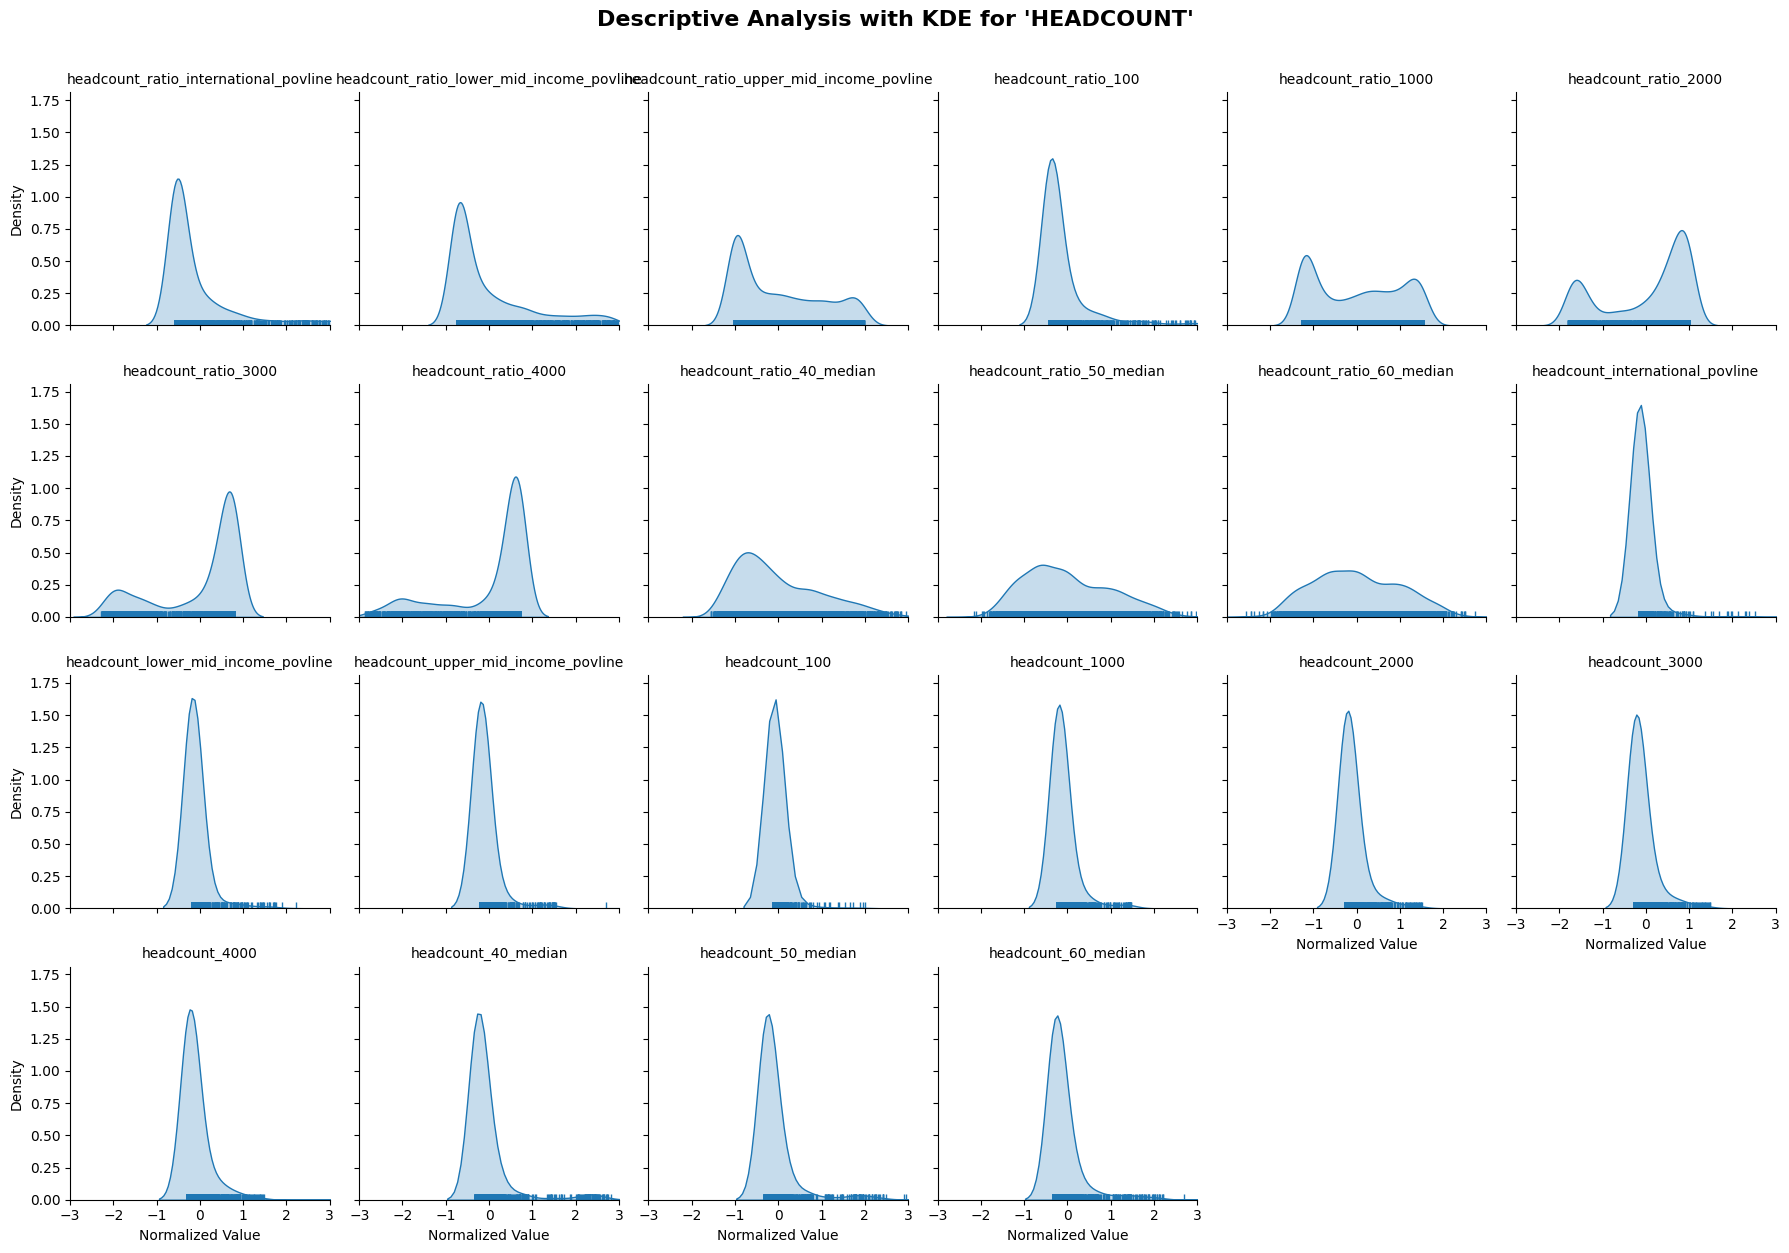

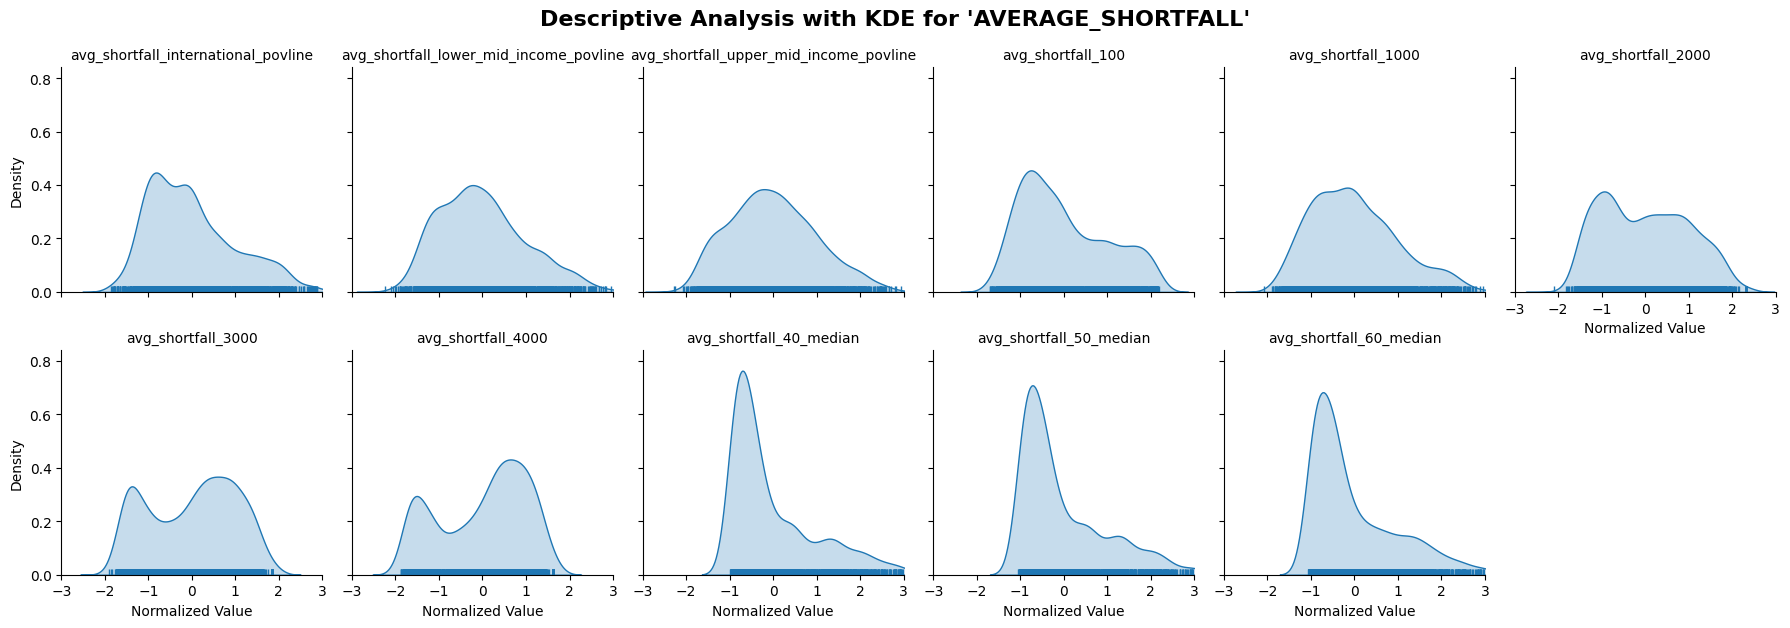

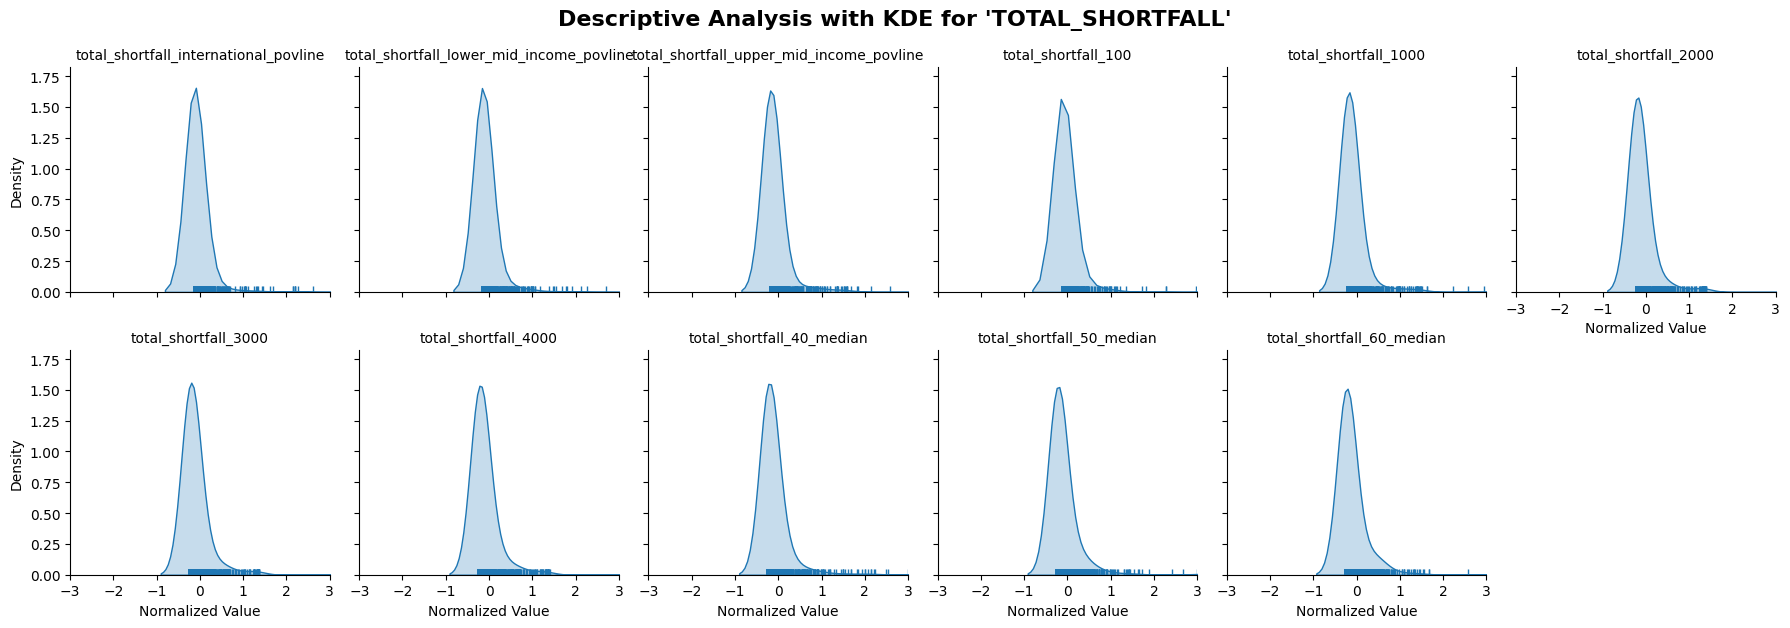

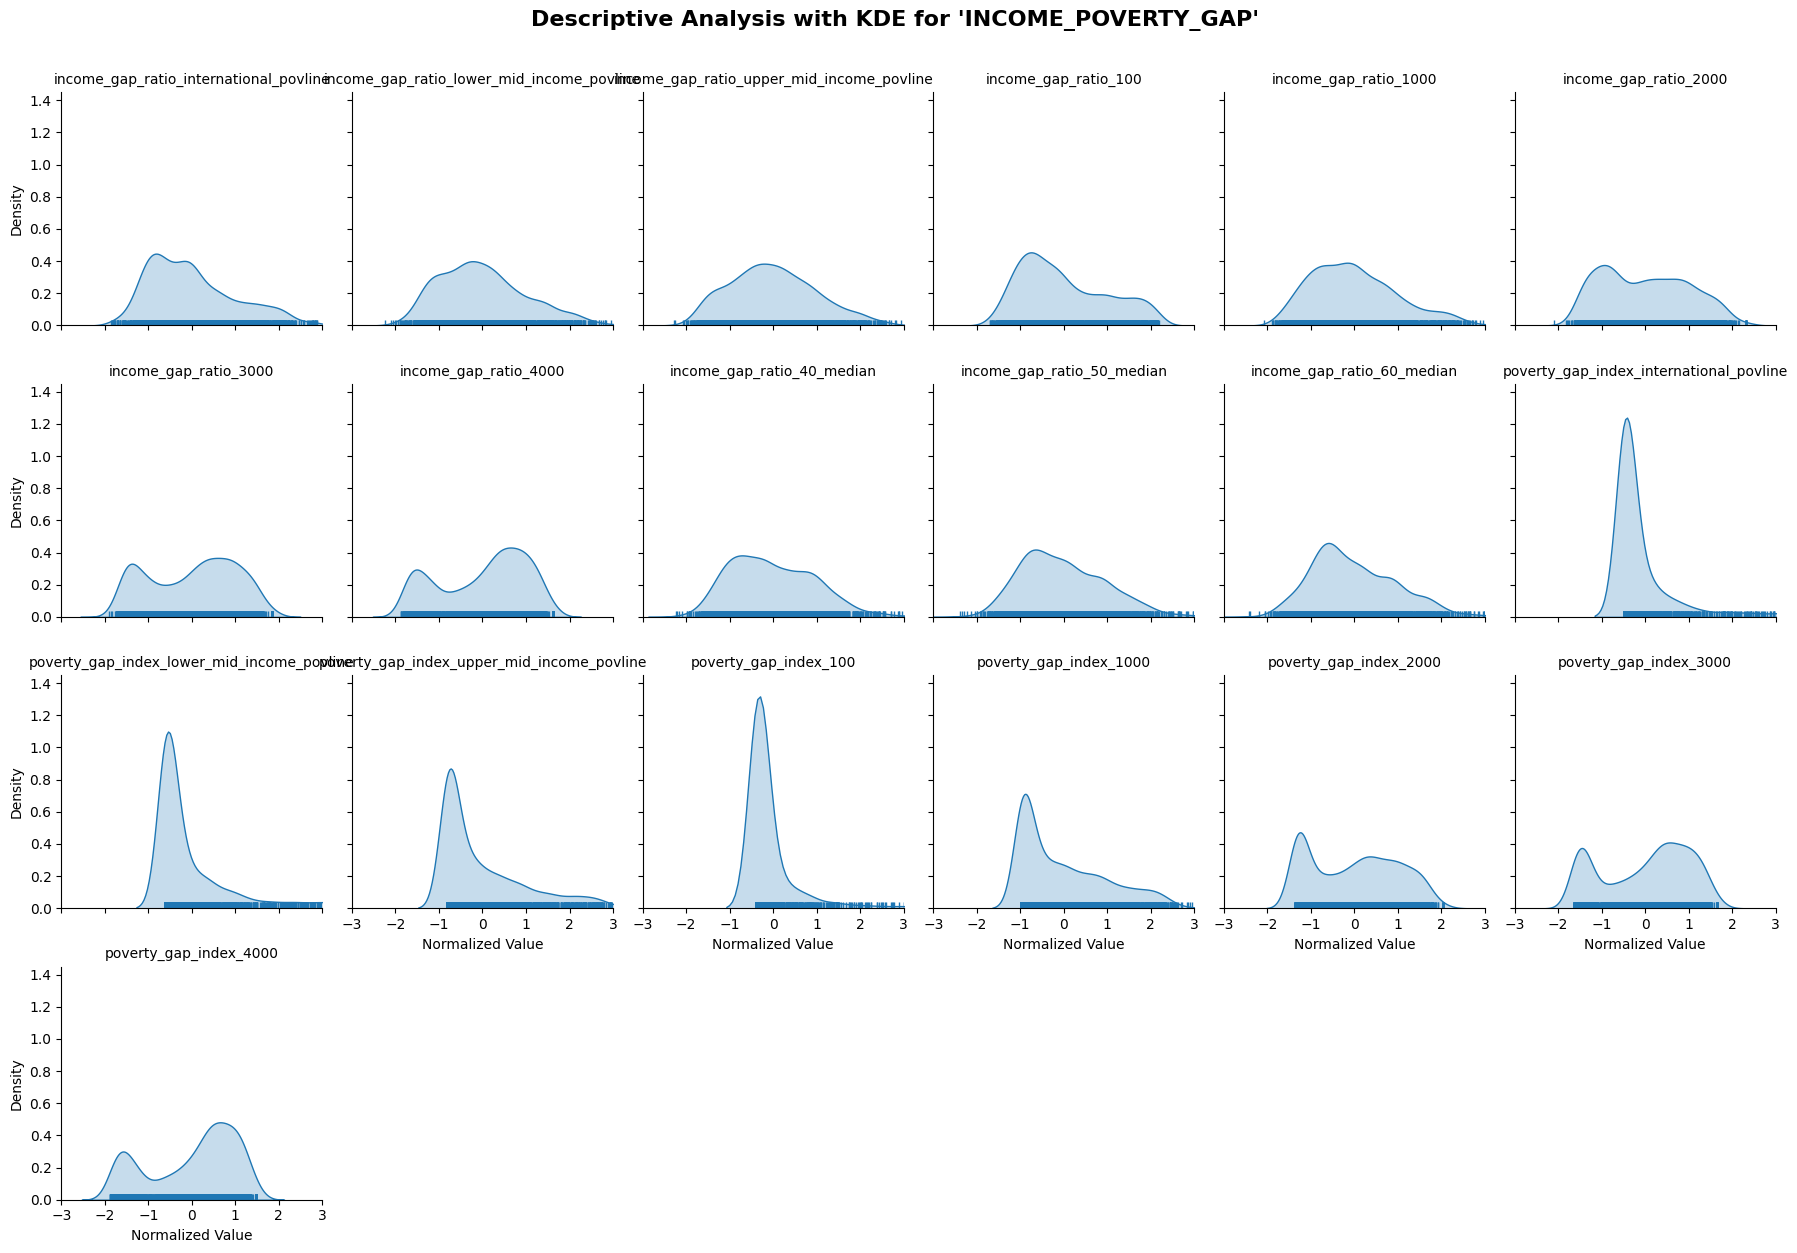

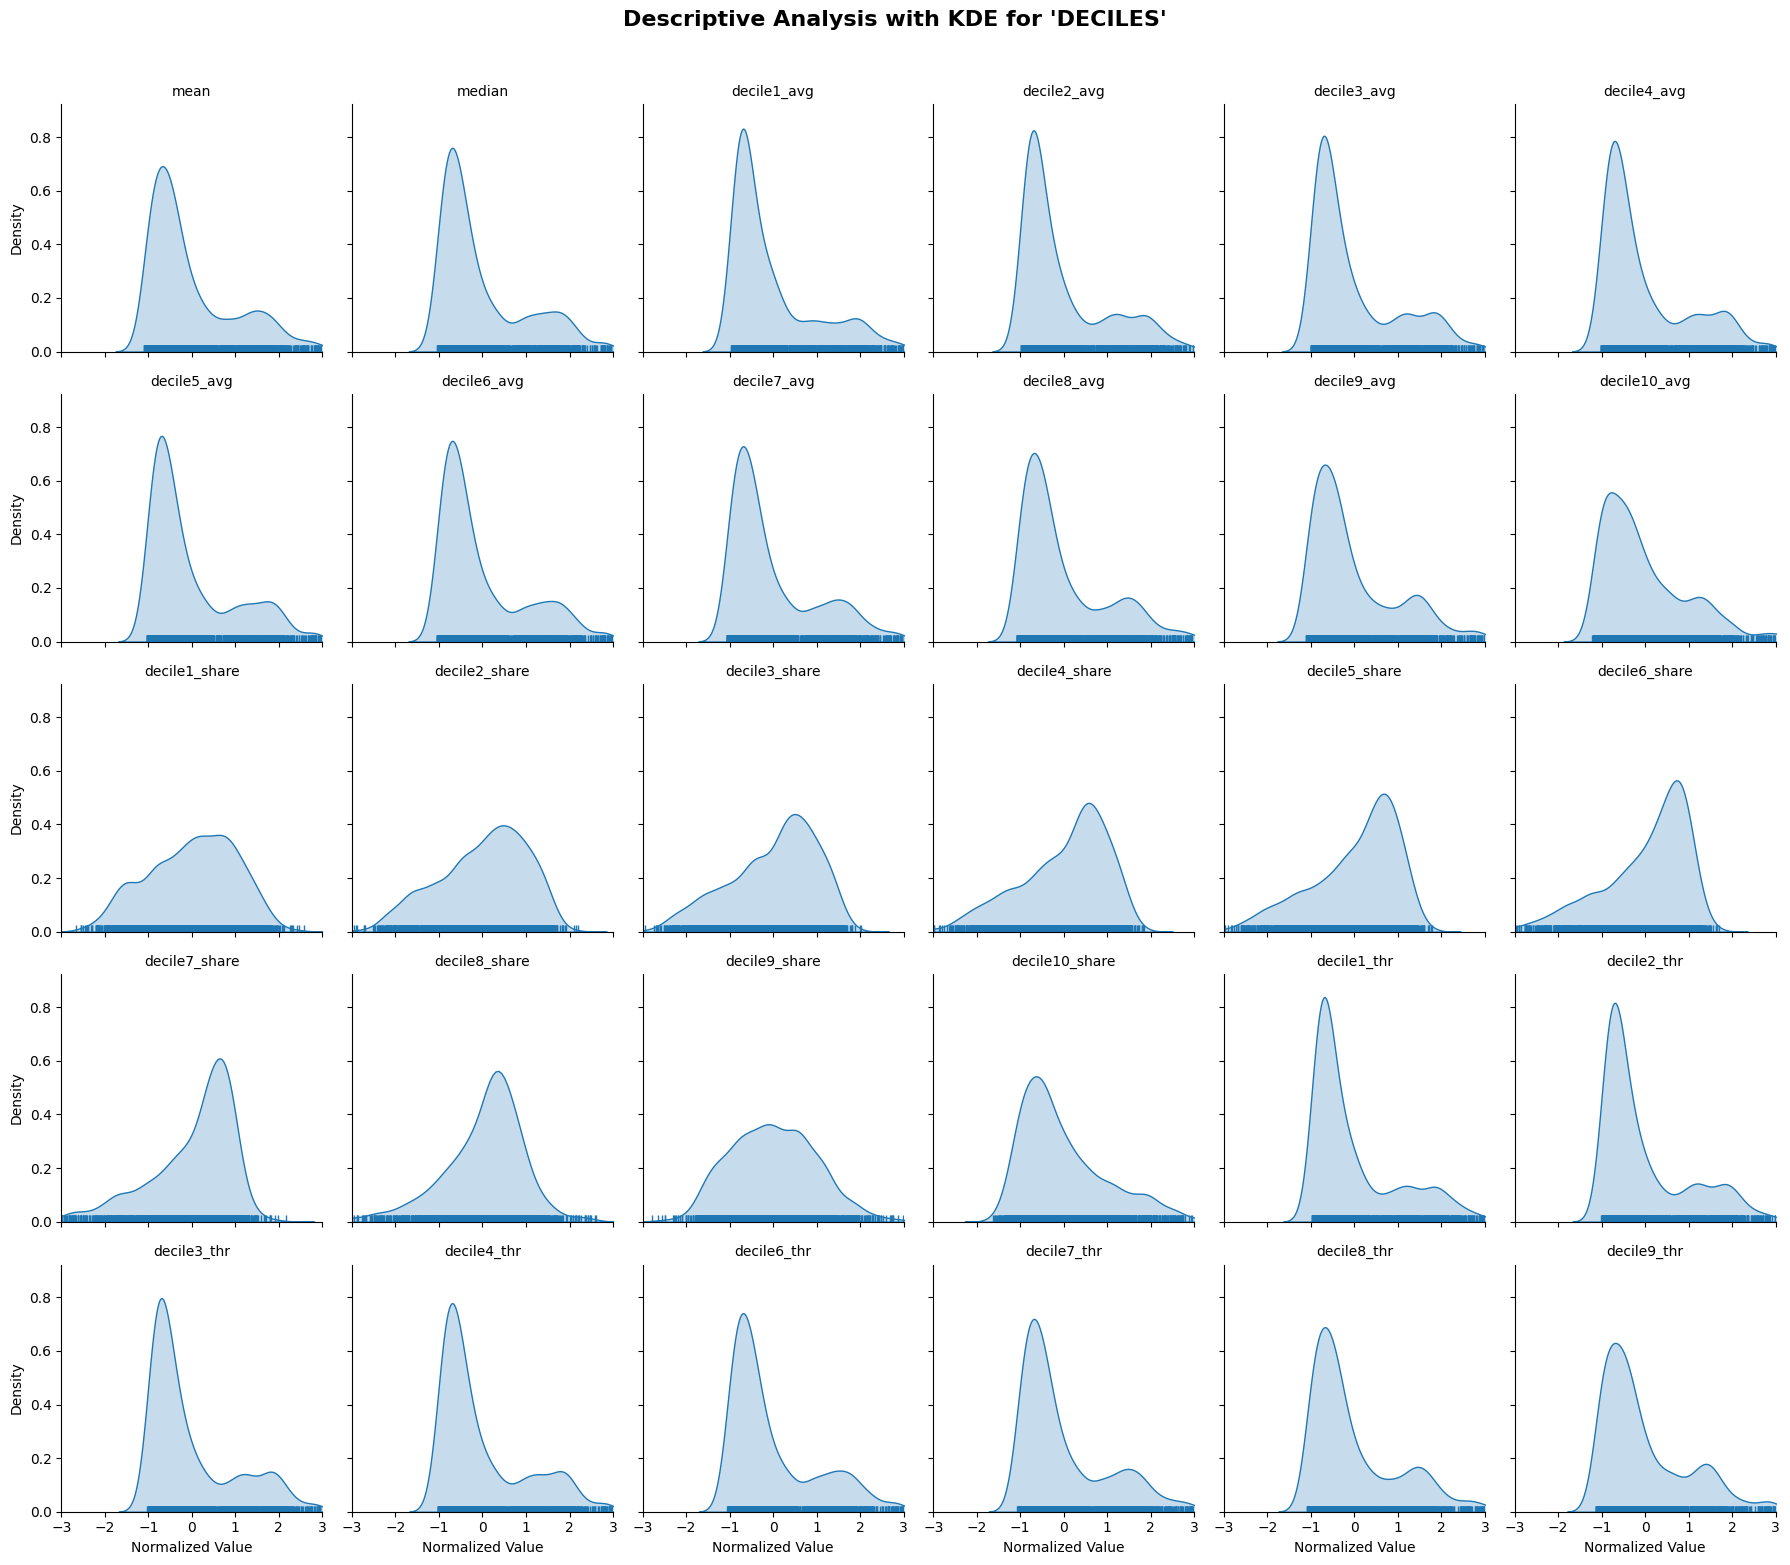

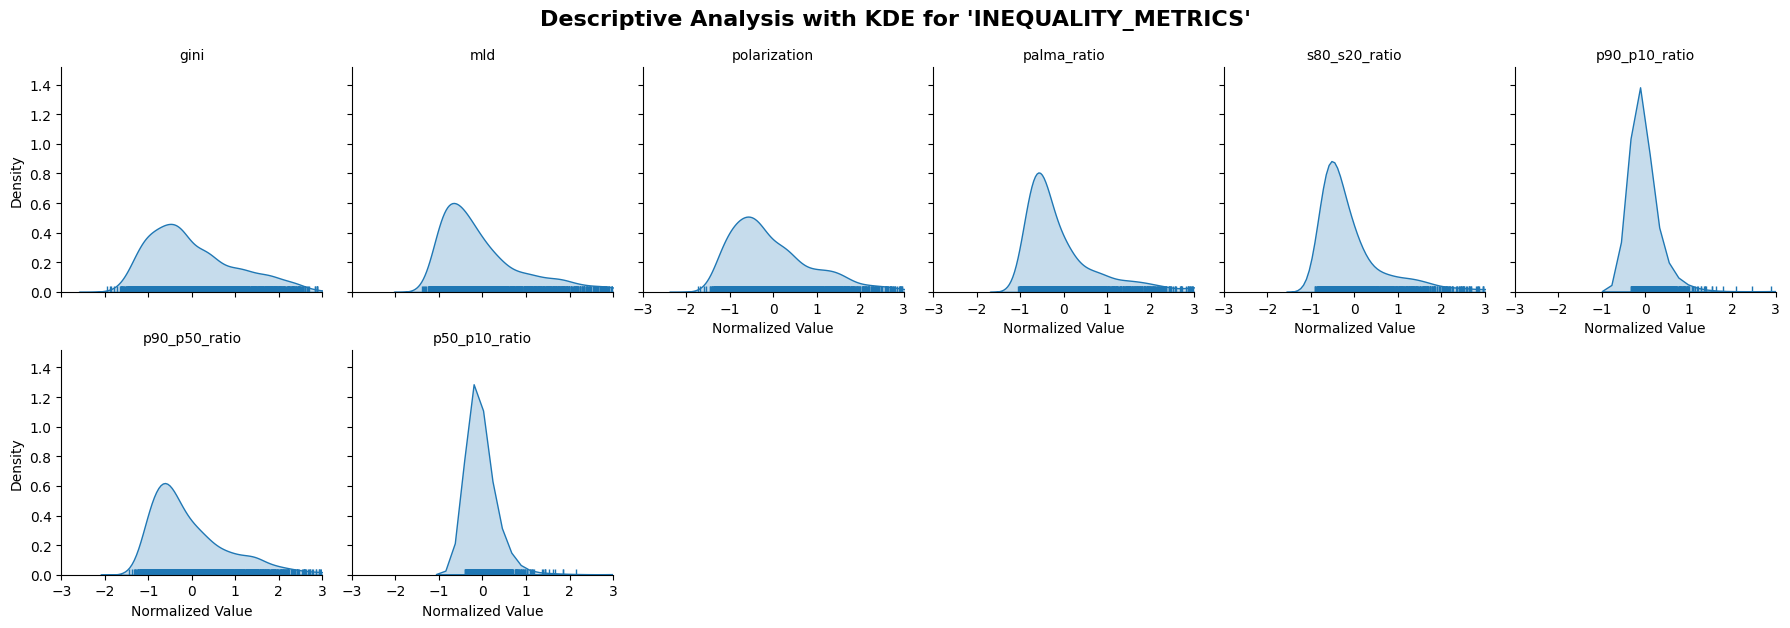

In [211]:
for name, dataset in datasets.items():
    # Normalize the dataset and transform it to long format
    data_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
    data_melted = data_scaled.melt(var_name='variable', value_name='value')

    # Create the KDE plots grid
    g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
    g.map(sns.kdeplot, "value", fill=True)
    g.map(sns.rugplot, "value")

    g.set(xlim=(-3, 3))  # Adjust X for a narrower range if the data is normalized
    g.set_titles("{col_name}")
    g.set_axis_labels("Normalized Value", "Density")
    g.tight_layout()
    g.fig.suptitle(f"Descriptive Analysis with KDE for '{name.upper()}'", y=1.04, fontsize=16, weight='bold')

    plt.show()

#### Transformación Box-Cox / Logarítmica de variables asimétricas (OPCIONAL)

Seleccionamos aquellas variables que, visualmente, parecen mostrar una fuerte asimetría.

In [212]:
boxcox_variables = [
    'headcount_ratio_international_povline', 'headcount_ratio_lower_mid_income_povline',
    'headcount_ratio_100', 'headcount_ratio_3000', 'headcount_ratio_4000',
    'headcount_international_povline', 'headcount_lower_mid_income_povline',
    'headcount_upper_mid_income_povline', 'headcount_100', 'headcount_1000',
    'headcount_2000', 'headcount_3000', 'headcount_4000', 'headcount_40_median',
    'headcount_50_median', 'headcount_60_median',

    'avg_shortfall_international_povline','avg_shortfall_40_median', 'avg_shortfall_50_median',
    'avg_shortfall_60_median',

    'total_shortfall_international_povline','total_shortfall_lower_mid_income_povline', 'total_shortfall_upper_mid_income_povline',
    'total_shortfall_100', 'total_shortfall_1000', 'total_shortfall_2000',
    'total_shortfall_3000', 'total_shortfall_4000', 'total_shortfall_40_median',
    'total_shortfall_50_median', 'total_shortfall_60_median',

    'income_gap_ratio_international_povline', 'income_gap_ratio_lower_mid_income_povline',
    'income_gap_ratio_upper_mid_income_povline', 'income_gap_ratio_40_median',
    'income_gap_ratio_50_median', 'income_gap_ratio_60_median',
    'poverty_gap_index_international_povline', 'poverty_gap_index_lower_mid_income_povline',
    'poverty_gap_index_upper_mid_income_povline', 'poverty_gap_index_100',

    'mean', 'median', 'decile1_avg', 'decile2_avg', 'decile3_avg', 'decile4_avg',
    'decile5_avg', 'decile6_avg', 'decile7_avg', 'decile8_avg', 'decile9_avg', 'decile10_avg',
    'decile1_share', 'decile2_share', 'decile3_share', 'decile4_share', 'decile5_share',
    'decile6_share', 'decile7_share', 'decile8_share', 'decile9_share',
    'decile1_thr', 'decile2_thr', 'decile3_thr', 'decile4_thr', 'decile6_thr',
    'decile7_thr', 'decile8_thr', 'decile9_thr',
    
    'gini', 'mld', 'polarization','palma_ratio', 's80_s20_ratio'
]


Transformamos las variables seleccionadas atendiendo a una transformación Box-Cox. Para evitar errores obviaremos aquellas observaciones con valor NaN, ya que la imputación se realiza en pasos posteriores.

In [213]:
# Dictionary to store the lambda parameters for each transformation
lambda_dict = {}

# Iterate over the list of variables to transform
for var in boxcox_variables:
    try:
        # Filter valid (non-null and positive) values
        valid_data = data[var].dropna()
        valid_data = valid_data[valid_data > 0]
        
        if valid_data.empty:
            print(f"The variable {var} has no valid positive values for transformation.")
            continue
        
        # Apply the Box-Cox transformation only to valid values
        transformed_data, lmbda = boxcox(valid_data)
        lambda_dict[var] = lmbda  # Store the lambda parameter
        
        # Update only the transformed values in the original DataFrame
        data.loc[valid_data.index, var] = transformed_data
        
        # Rename the transformed column
        data.rename(columns={var: f'bx_{var}'}, inplace=True)
    
    except Exception as e:
        print(f"Error transforming the variable {var}: {e}")

In [214]:
feat_num = [feat for feat in data.columns if feat not in feat_cat]
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

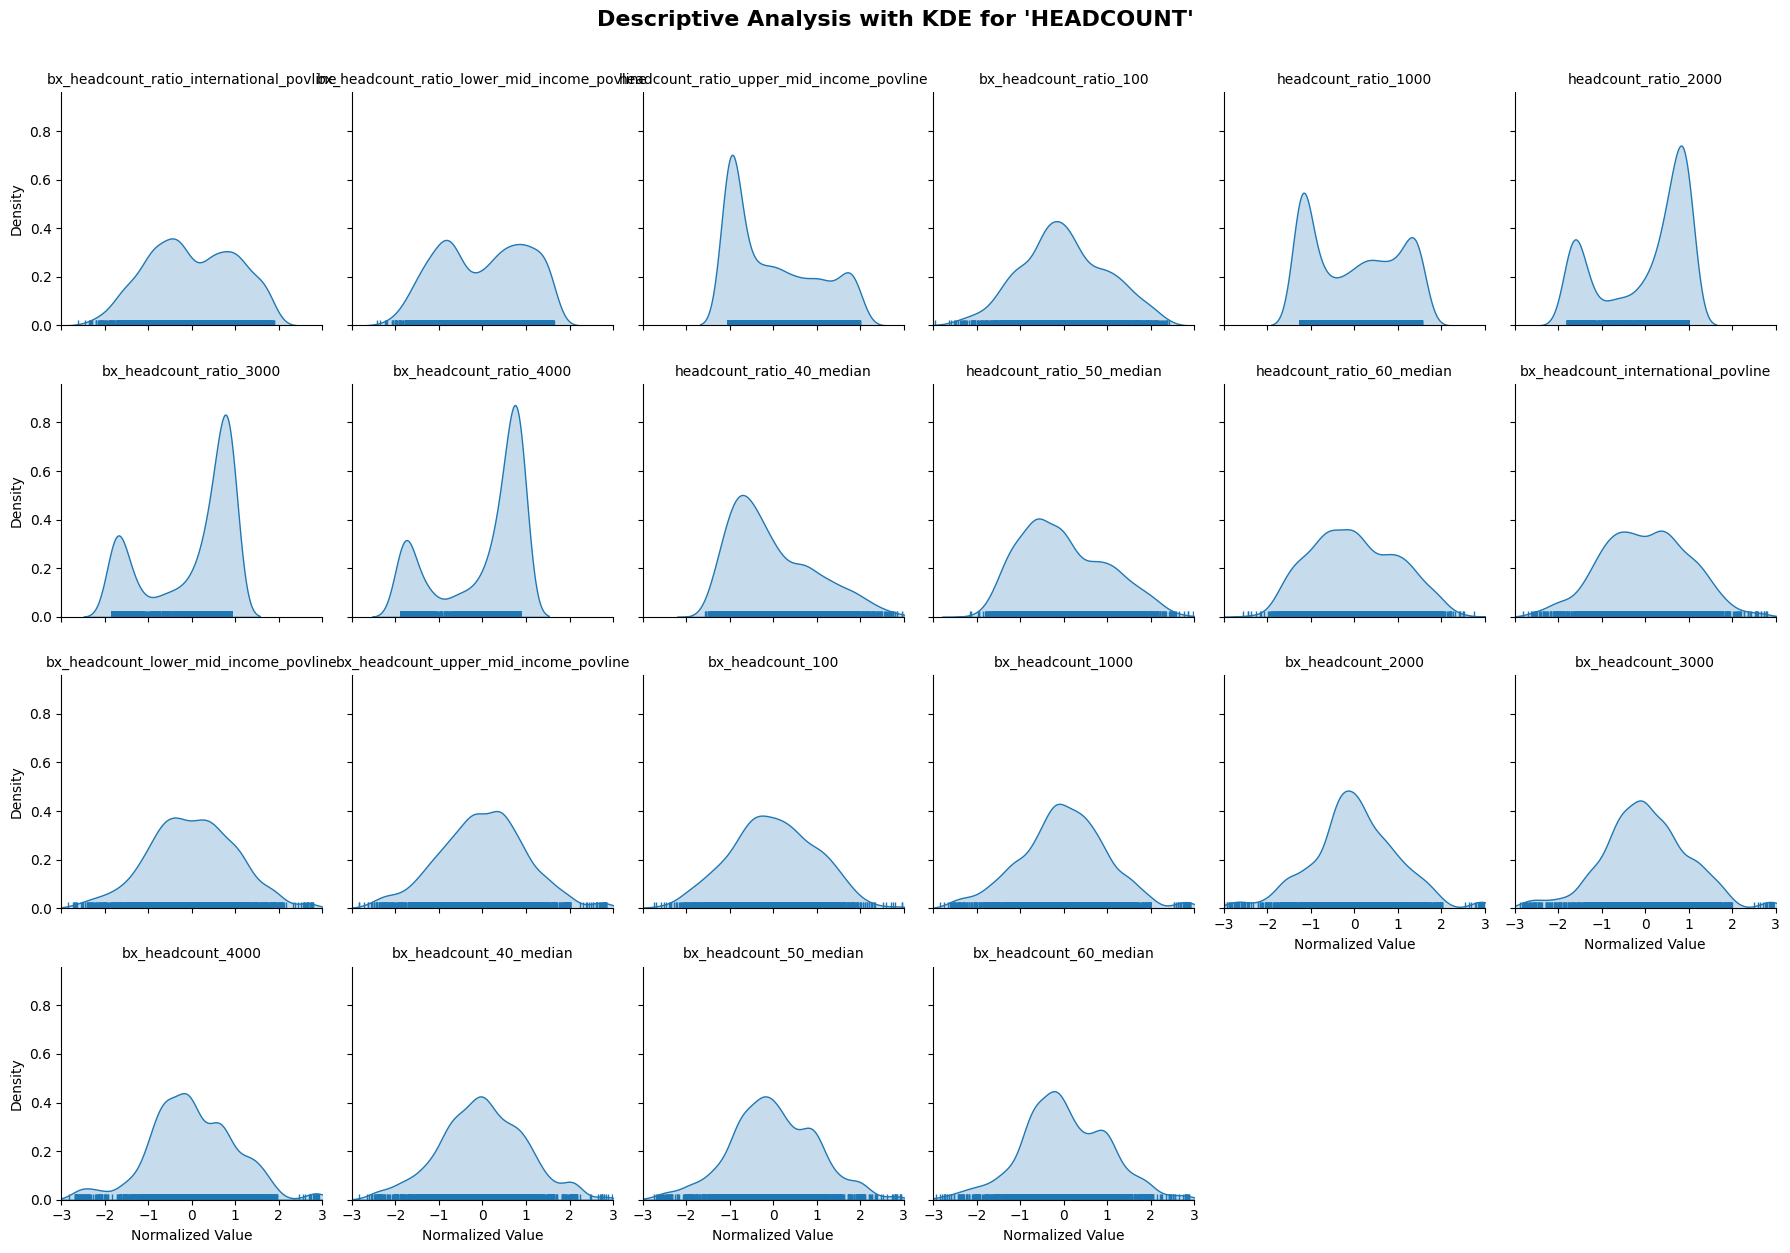

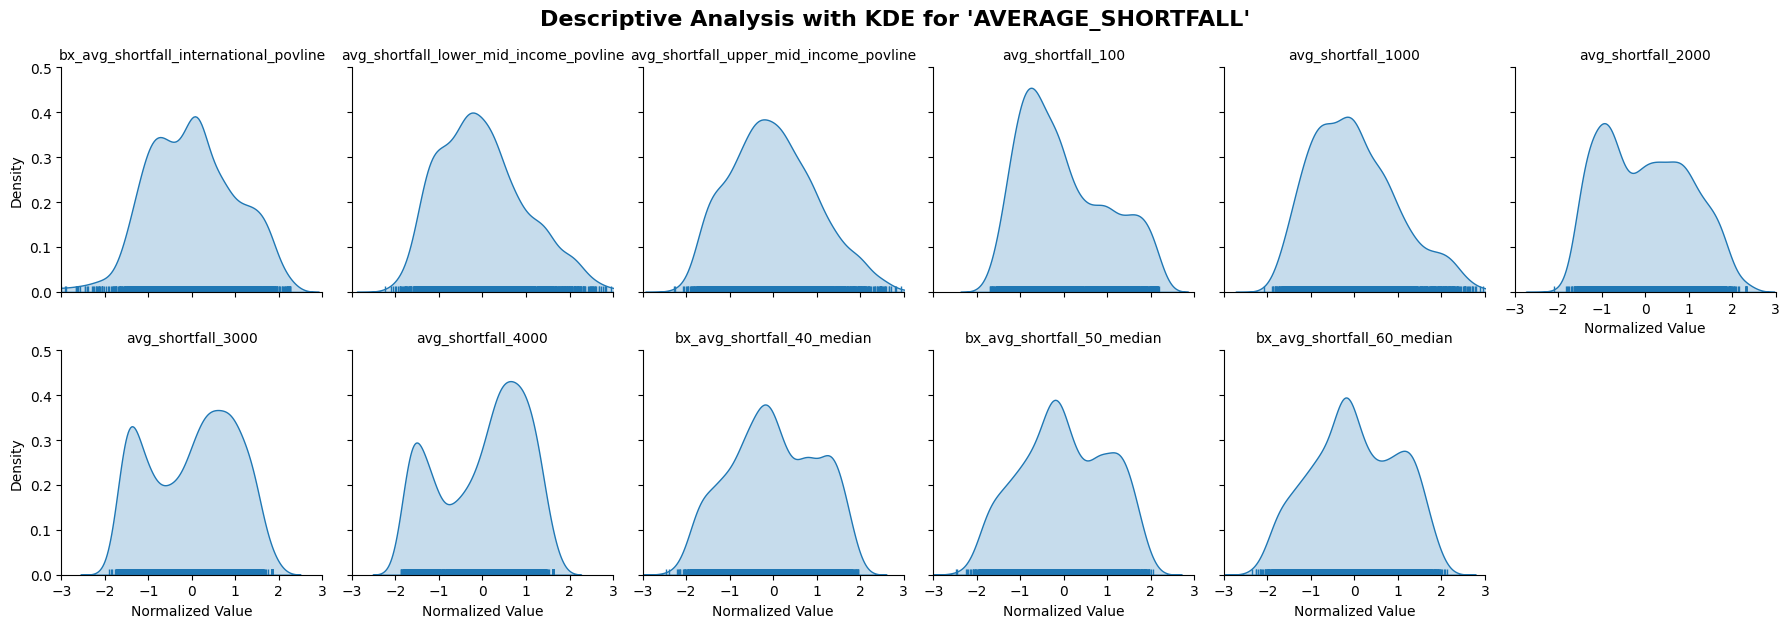

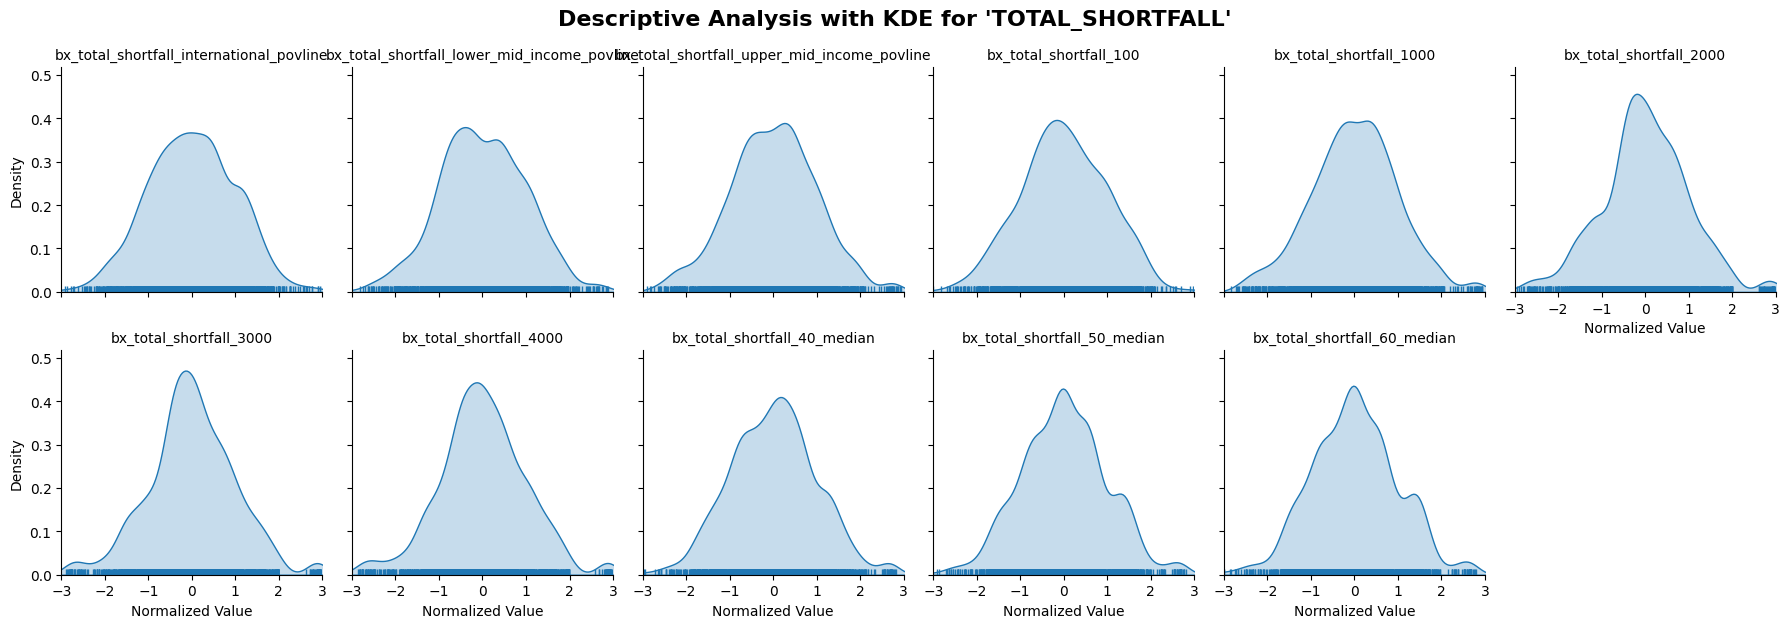

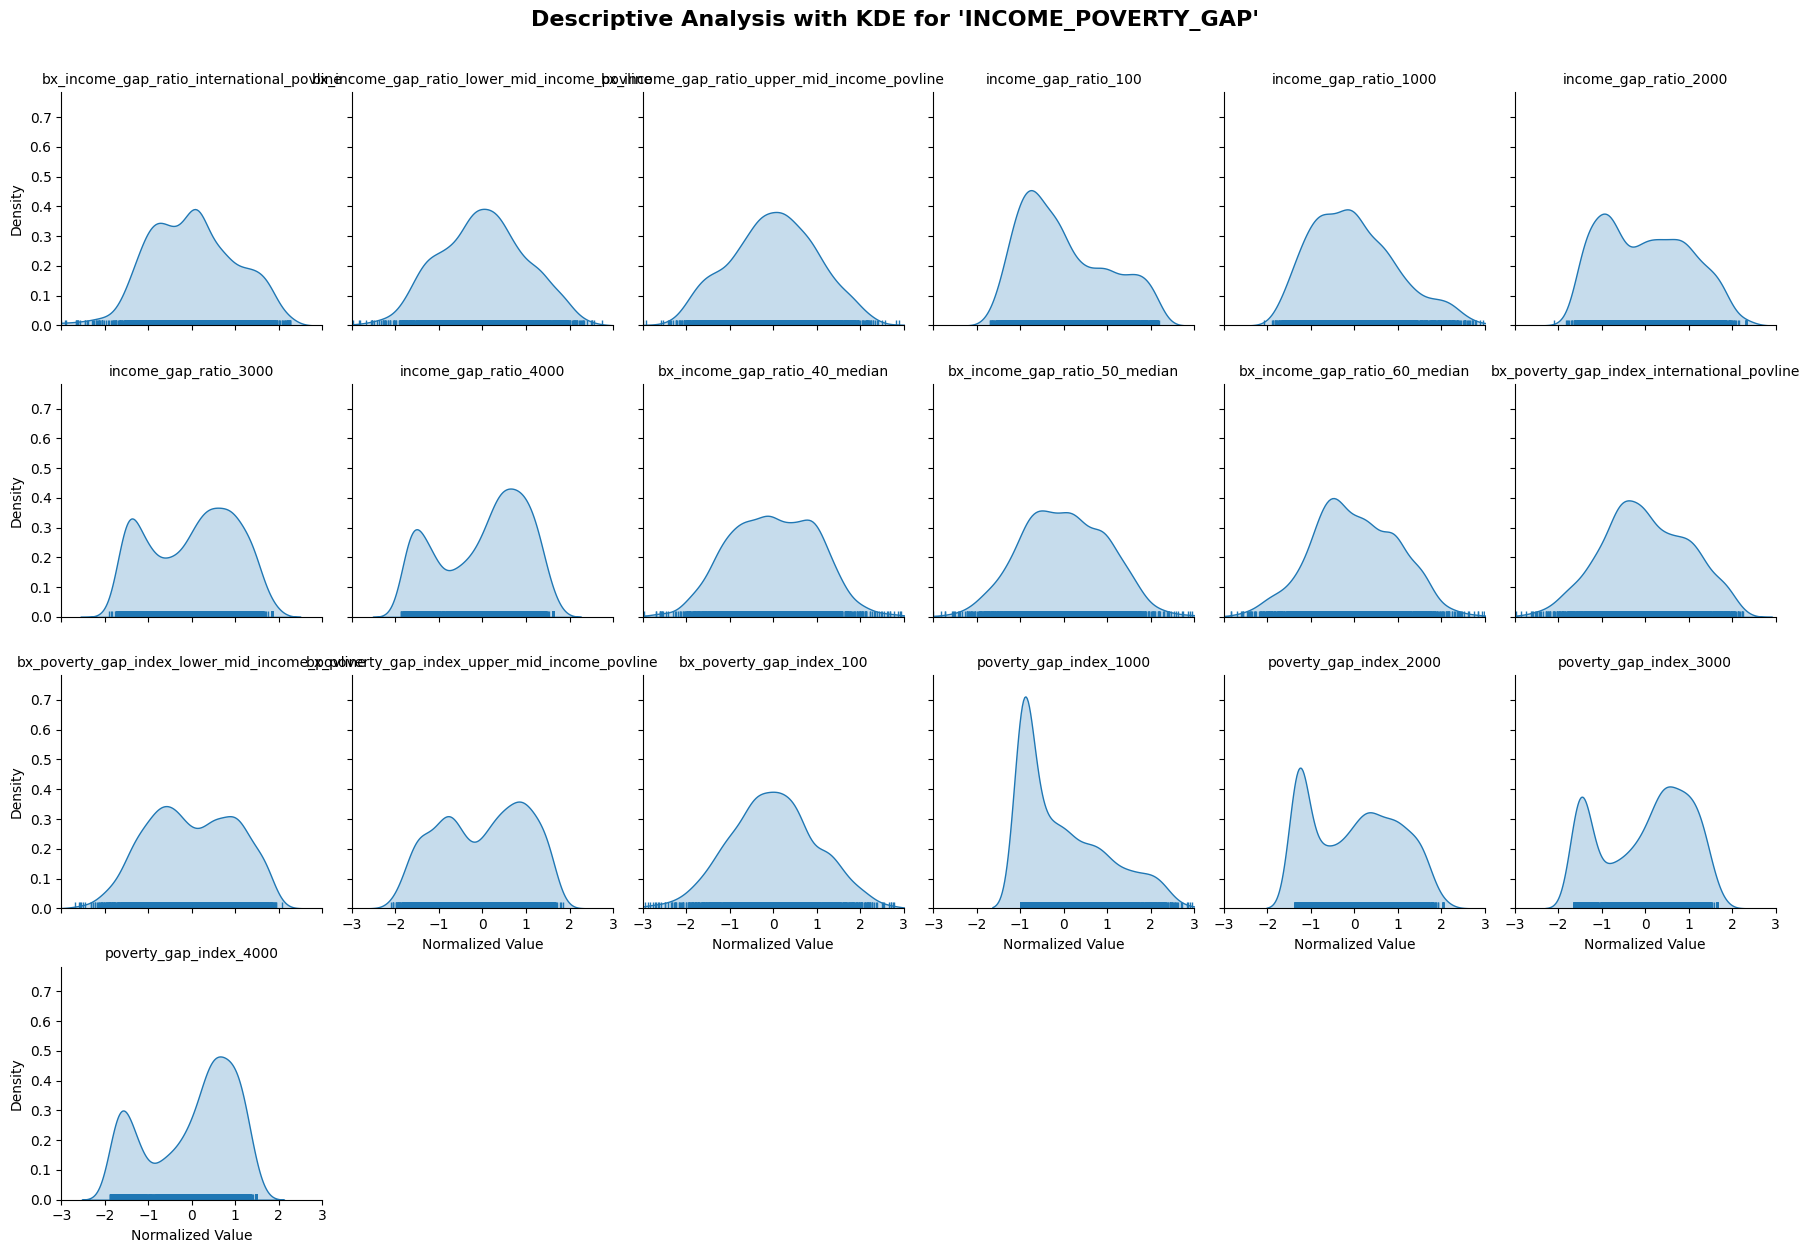

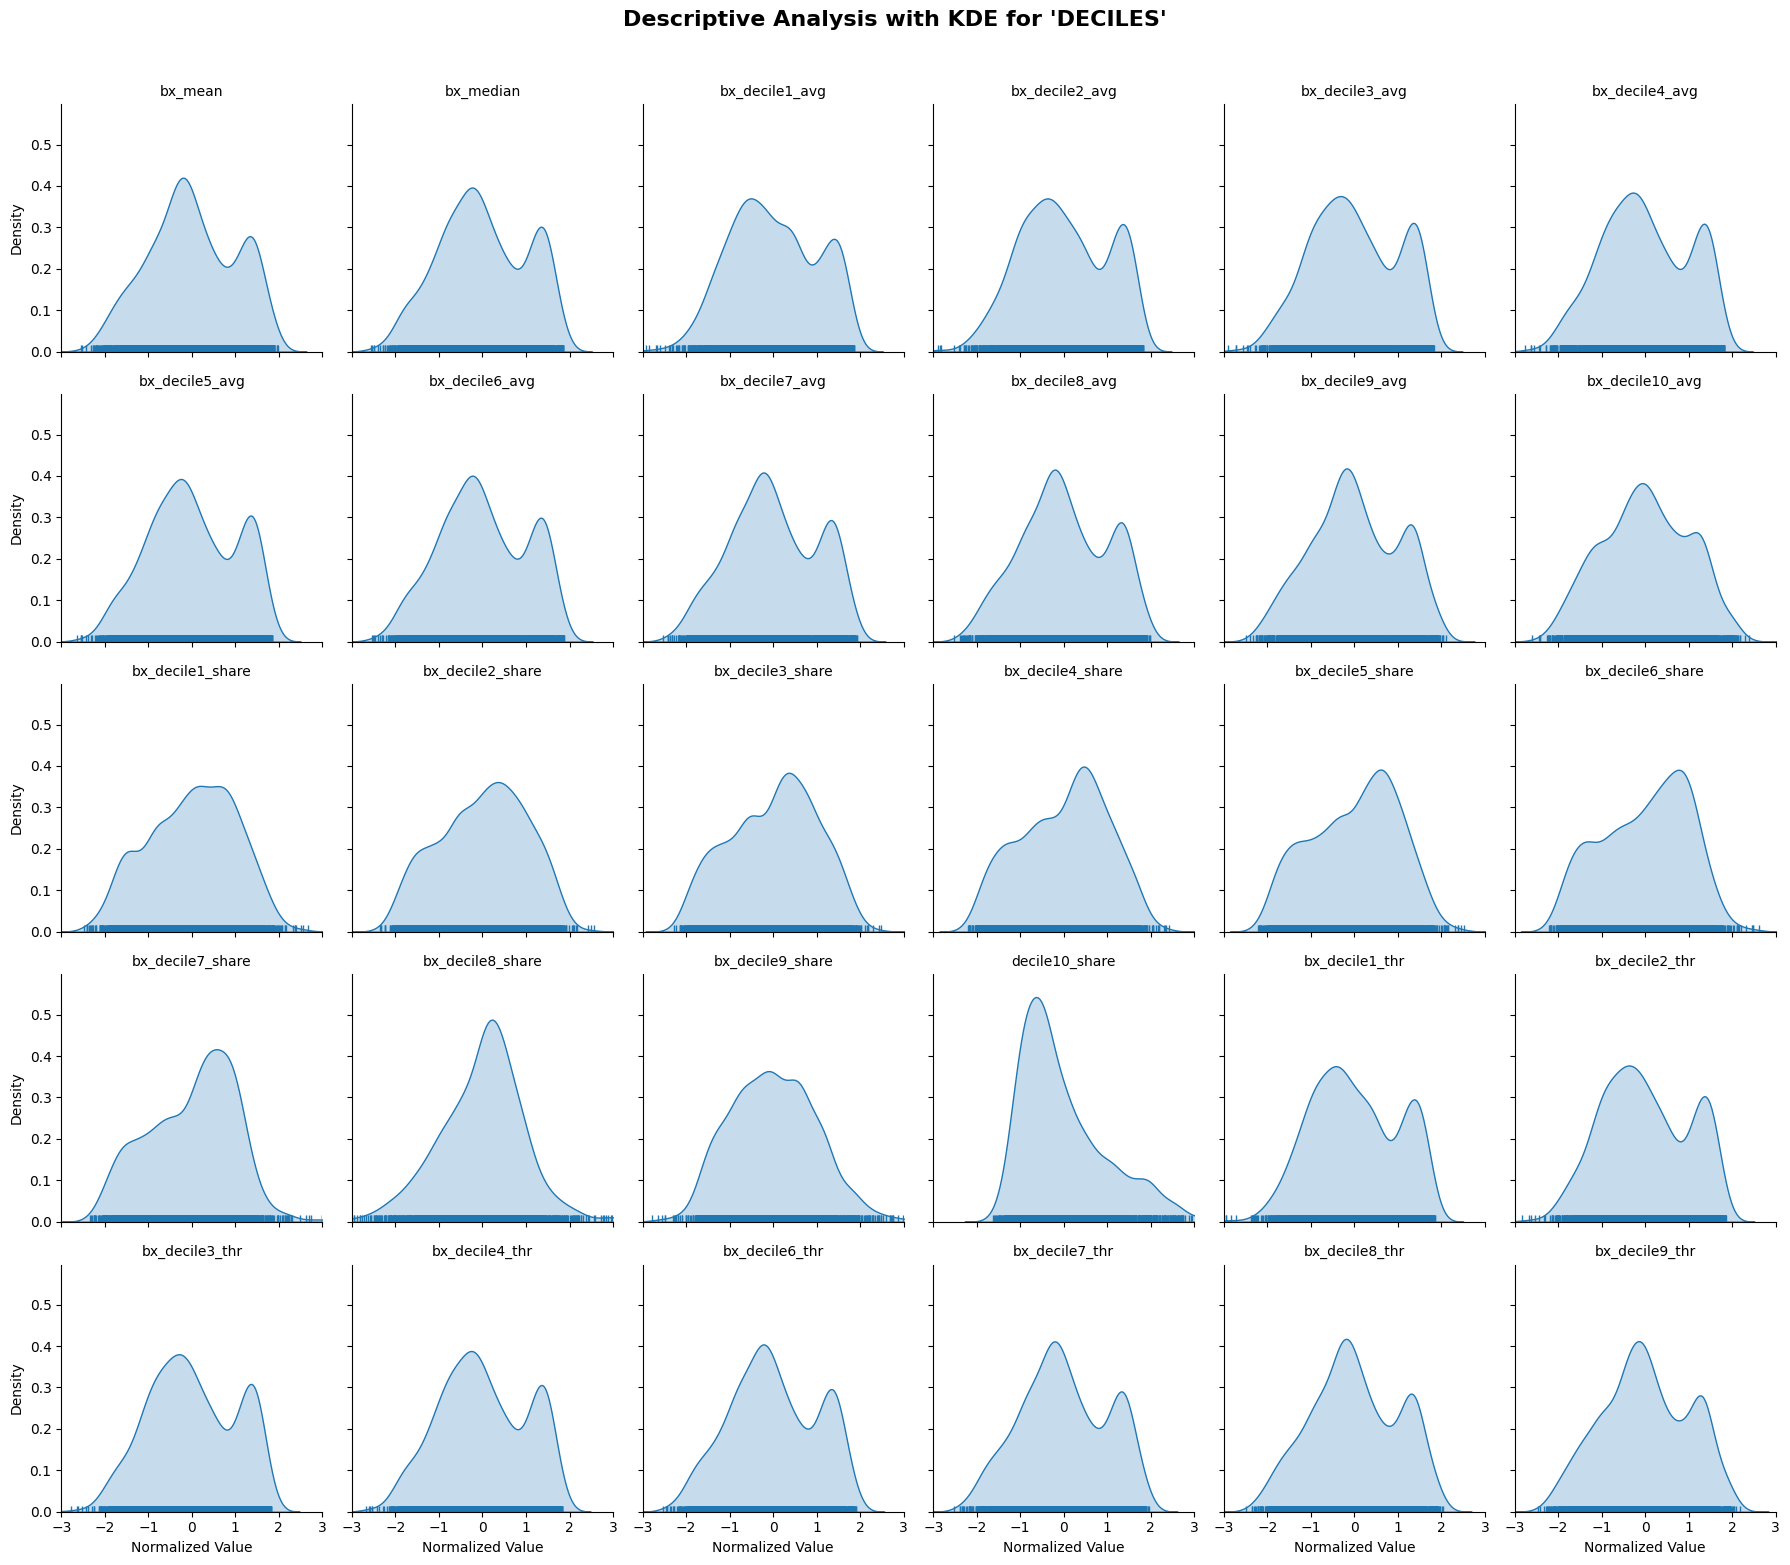

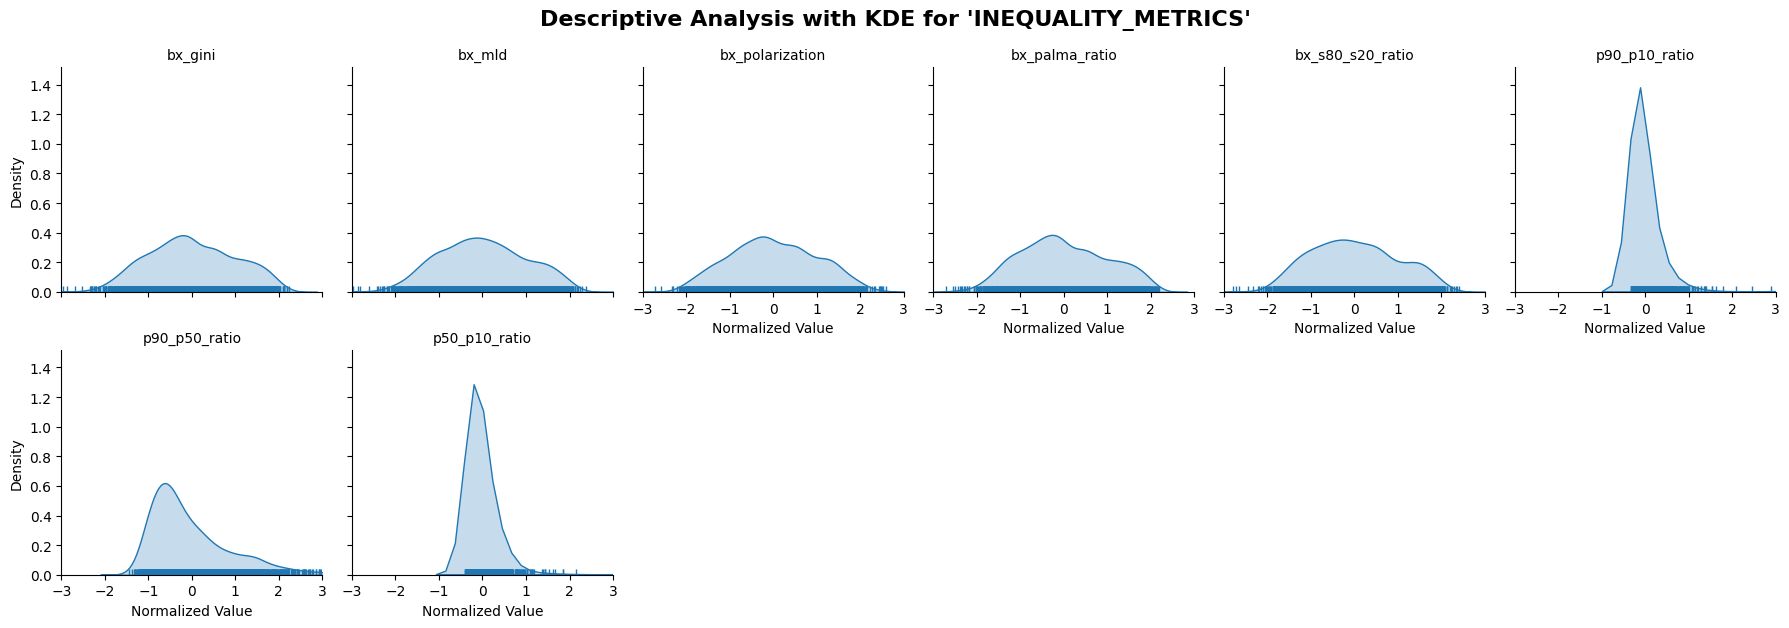

In [215]:
for name, dataset in datasets.items():
    # Normalize the dataset and transform it to long format
    data_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
    data_melted = data_scaled.melt(var_name='variable', value_name='value')

    # Create the KDE plots grid
    g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
    g.map(sns.kdeplot, "value", fill=True)
    g.map(sns.rugplot, "value")


    g.set(xlim=(-3, 3))  # Adjust X for a narrower range if the data is normalized
    g.set_titles("{col_name}")
    g.set_axis_labels("Normalized Value", "Density")
    g.tight_layout()
    g.fig.suptitle(f"Descriptive Analysis with KDE for '{name.upper()}'", y=1.04, fontsize=16, weight='bold')

    plt.show()

### 3. Análisis e imputación de datos perdidos <a class="anchor" id="seccion_3"></a>

Observar el porcentaje de datos perdidos por columna

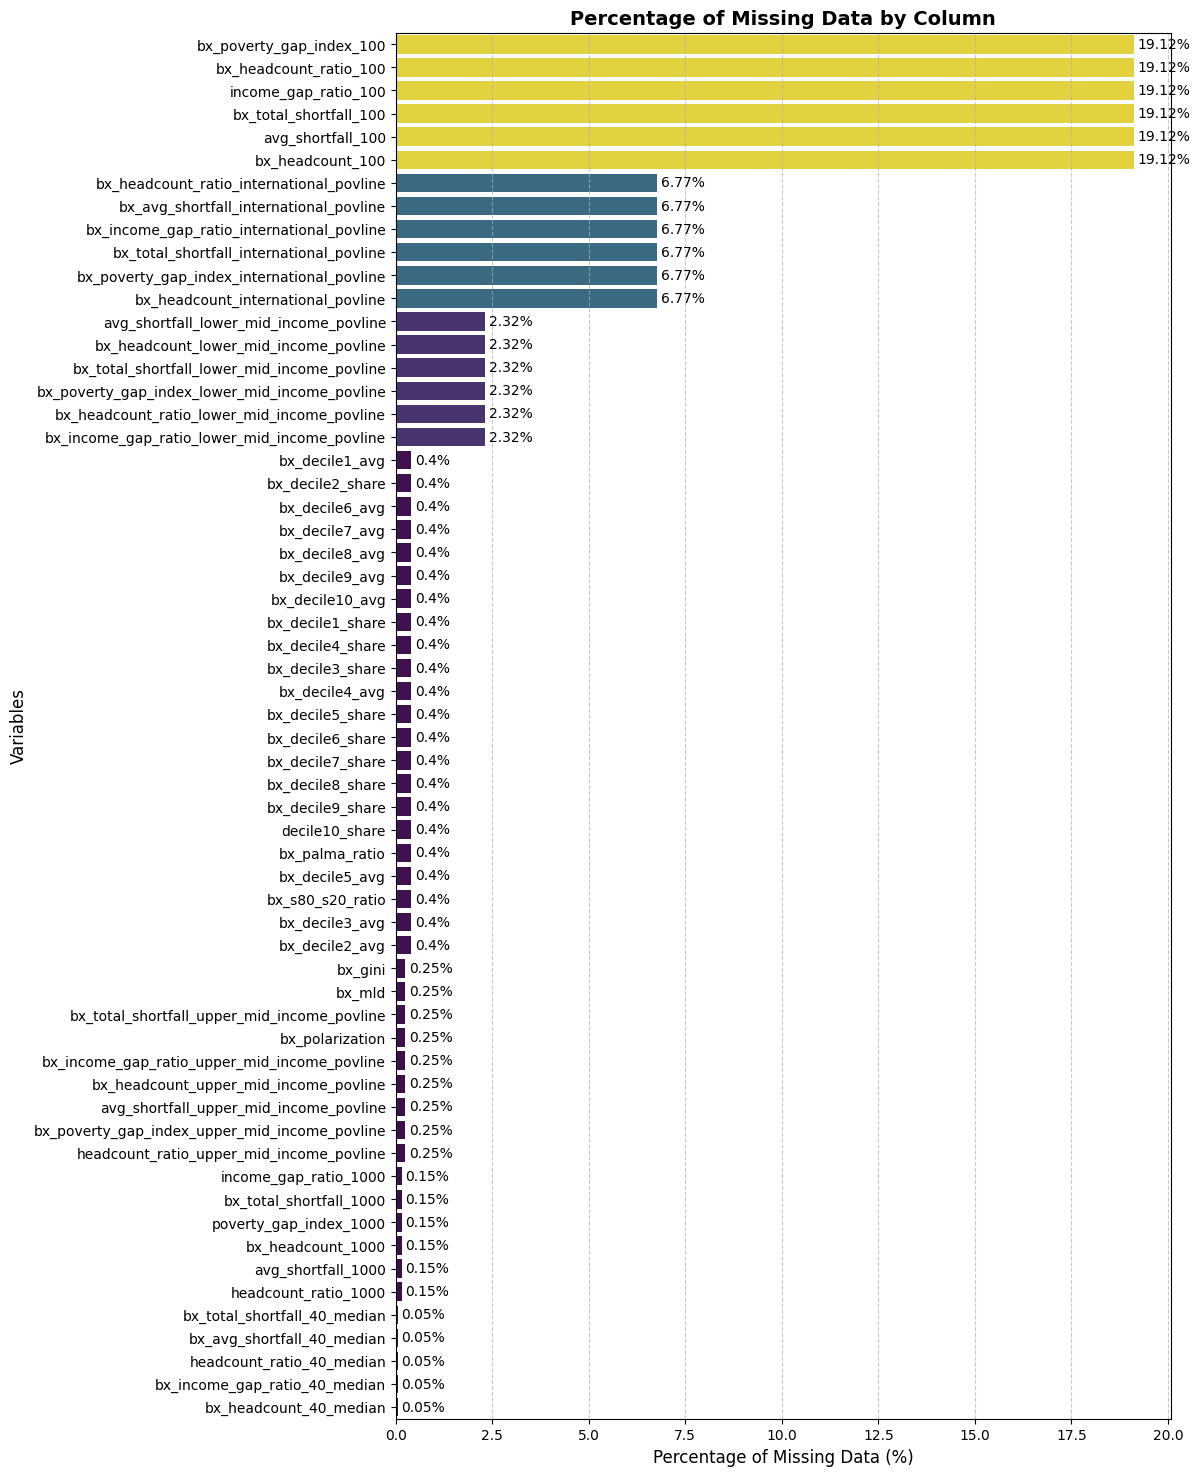

In [216]:
# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, 
                 palette="viridis", hue=missing_table['Percentage of Missing Data'], legend=False)
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Eliminamos aquellas filas o países con una gran cantidad de datos perdidos, ya que corresponden a un número muy bajo de instancias del cual podemos prescindir.

In [217]:
data.dropna(subset=['decile10_share'], inplace=True)

Antes de imputar los datos perdidos restantes, solucionamos los outliers. Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.

In [218]:
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

In [219]:
# # Apply outlier handling to 'data'
# data, data_outliers_replaced, perc_replaced = handleData.replace_outliers_with_nan(data, confidence_interval=0.9973)
# print(f"Number of outliers replaced with NaN: {data_outliers_replaced}")
# print(f"Percentage of cells replaced: {perc_replaced:.2f}%")


# # Apply outlier handling to each dataset in the dictionary and visualize with Z-score normalization
# for name, dataset in datasets.items():

#     # Normalize without handling outliers
#     normalized_dataset_no_outliers = dataset.apply(zscore, nan_policy='omit')
    
#     # Replace outliers with NaN in each dataset and normalize again
#     datasets[name], cells_replaced, _ = handleData.replace_outliers_with_nan(normalized_dataset_no_outliers, confidence_interval=0.9973)
#     normalized_dataset_outliers_handled = datasets[name].apply(zscore, nan_policy='omit')
    
#     # Create a figure with 2 subplots (one above the other) to compare before and after handling outliers
#     fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    
#     # Plot Z-score normalized dataset before outlier handling
#     sns.boxplot(data=normalized_dataset_no_outliers, orient="h", ax=axes[0])
#     axes[0].set_title(f"Before Outlier Handling", fontdict={'weight': 'bold', 'size': 12})
#     axes[0].set_xlabel("Z-score Normalized Values")
#     axes[0].set_ylabel("Features")
#     axes[0].grid(axis='x', linestyle='--', alpha=0.7)
    
#     # Plot Z-score normalized dataset after outlier handling
#     sns.boxplot(data=normalized_dataset_outliers_handled, orient="h", ax=axes[1])
#     axes[1].set_title(f"After Outlier Handling. ({cells_replaced} cells to NaN)", fontdict={'weight': 'bold', 'size': 12})
#     axes[1].set_xlabel("Z-score Normalized Values")
#     axes[1].set_ylabel("Features")
#     axes[1].grid(axis='x', linestyle='--', alpha=0.7)

    
#     # Adjust the layout and add suptitle
#     plt.suptitle(f"Z-score Normalized Box Plot", y=1, fontsize=14, fontweight='bold')
#     plt.tight_layout()
    
#     # Show the plot
#     plt.show()

Imputar con MICE regresión lineal los missing restantes

In [220]:
# Solve numerical missing data
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)

# Ignore convergence warning while imputing
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    data[feat_num] = imputer.fit_transform(data[feat_num])

data = data.reset_index(drop=True)

Detectar y eliminar los outliers multivariantes mediante un test Hotelling T2 (como t de Student pero multivariante). El test mide la distancia de una observación en un el conjunto de datos multivariante respecto de la media global, considerando la estructura de correalación y varianza. Ajusta las distancias considerando las covarianzas.

In [221]:
# # Select the numeric columns and apply PCA (ensure covariance matrix invertible)
# numeric_data = data.iloc[:, 5:107]
# pca = PCA()
# pca_data = pca.fit_transform(numeric_data)  

# # Compute the mean and covariance matrix in the PCA space
# mean_vector = np.mean(pca_data, axis=0)
# cov_matrix = np.cov(pca_data, rowvar=False)

# # Calculate Hotelling's T² statistic in the PCA space
# inv_cov_matrix = np.linalg.inv(cov_matrix) # inverse of the covariance matrix 
# centered_data = pca_data - mean_vector
# T2_statistics = np.einsum('ij,jk,ik->i', centered_data, inv_cov_matrix, centered_data)  # Efficient T² calculation

# # Determine the critical threshold
# n, p = numeric_data.shape
# threshold = f.ppf(0.9973, dfn=p, dfd=n-p) * p * (n-1) / (n-p) 

# outliers = np.where(T2_statistics > threshold)[0]
# num_outliers = len(outliers)
# print(f"Number of multivariate outliers detected: {num_outliers}")

# data.drop(index=outliers, inplace=True)
# data.reset_index(drop=True, inplace= True)
# print(f"The cleaned dataset now has {data.shape[0]} rows.")

# # Mahalanobis distance plot to visualize multivariate anomalies
# mahalanobis_distances = np.sqrt(T2_statistics)
# critical_value = np.sqrt(threshold)

# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(mahalanobis_distances)), mahalanobis_distances, label="Mahalanobis Distances")
# plt.axhline(y=critical_value, color='r', linestyle='--', label=f"Critical Threshold ({critical_value:.2f})")
# plt.xlabel("Observation Index")
# plt.ylabel("Mahalanobis Distance")
# plt.title("Multivariate Outlier Detection with PCA", fontsize=14, weight='bold')
# plt.legend()
# plt.show()


In [222]:
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

### 4. Análisis de correlaciones y reducción de la dimensionalidad <a class="anchor" id="seccion_4"></a>


Realizar un análisis de correlaciones y obtener un gráfico de pareto tras PCA por subgrupos.

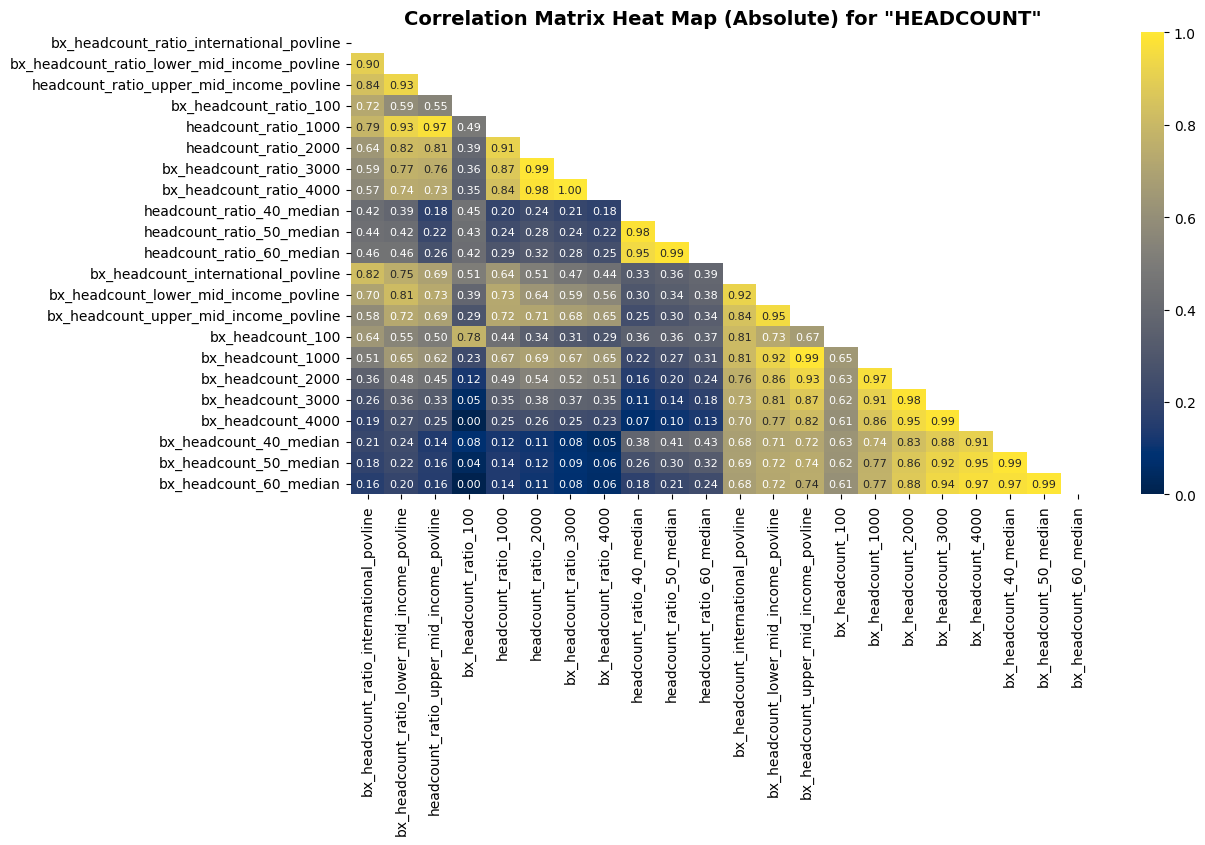

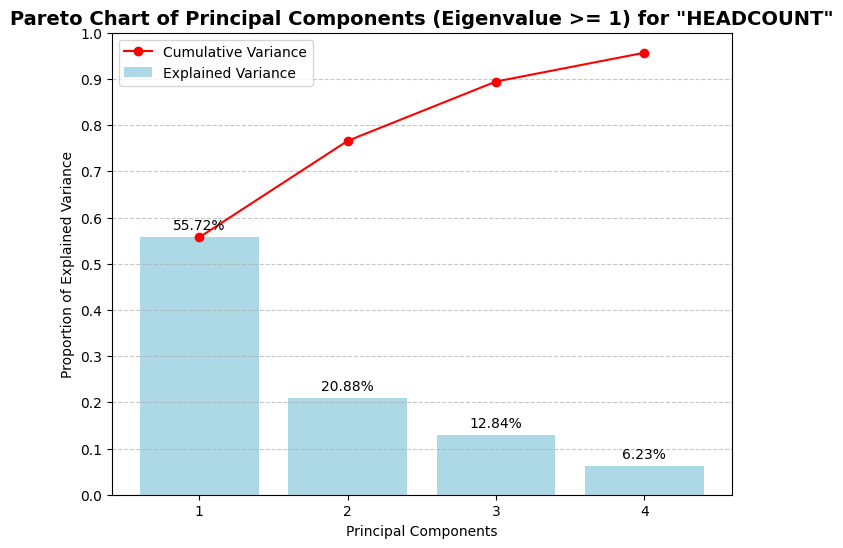

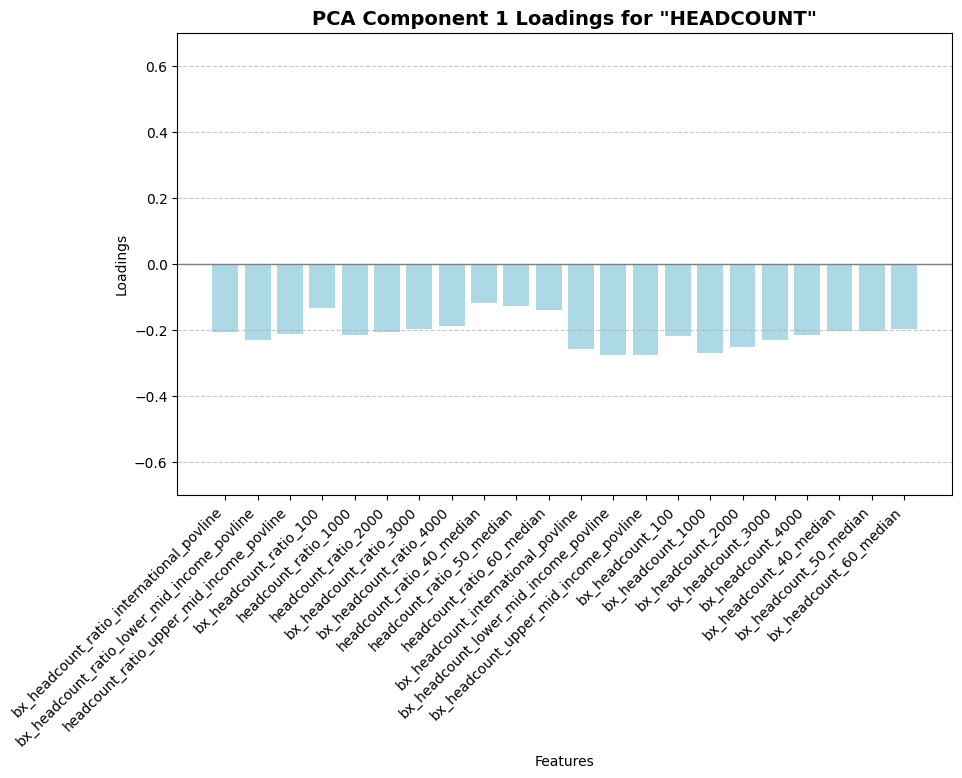

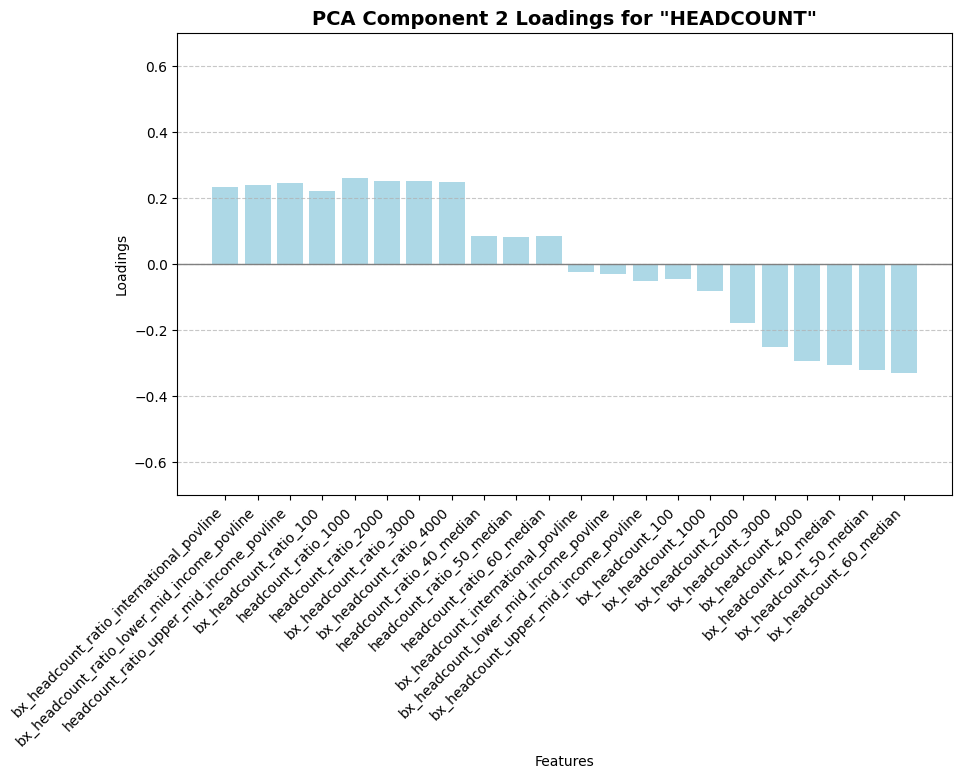

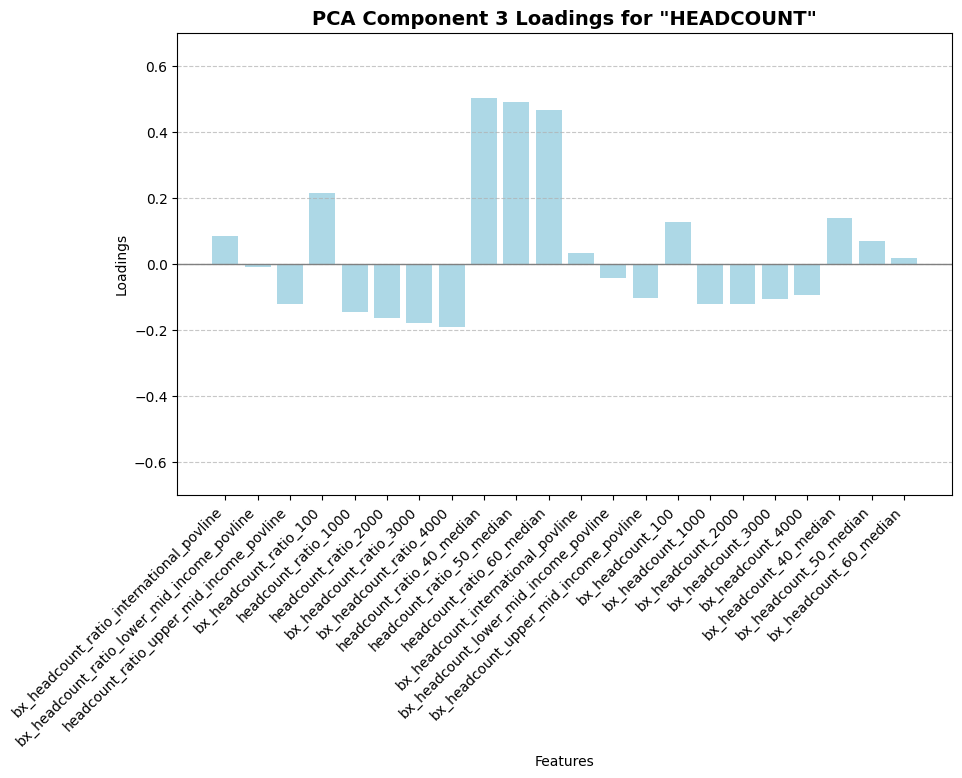

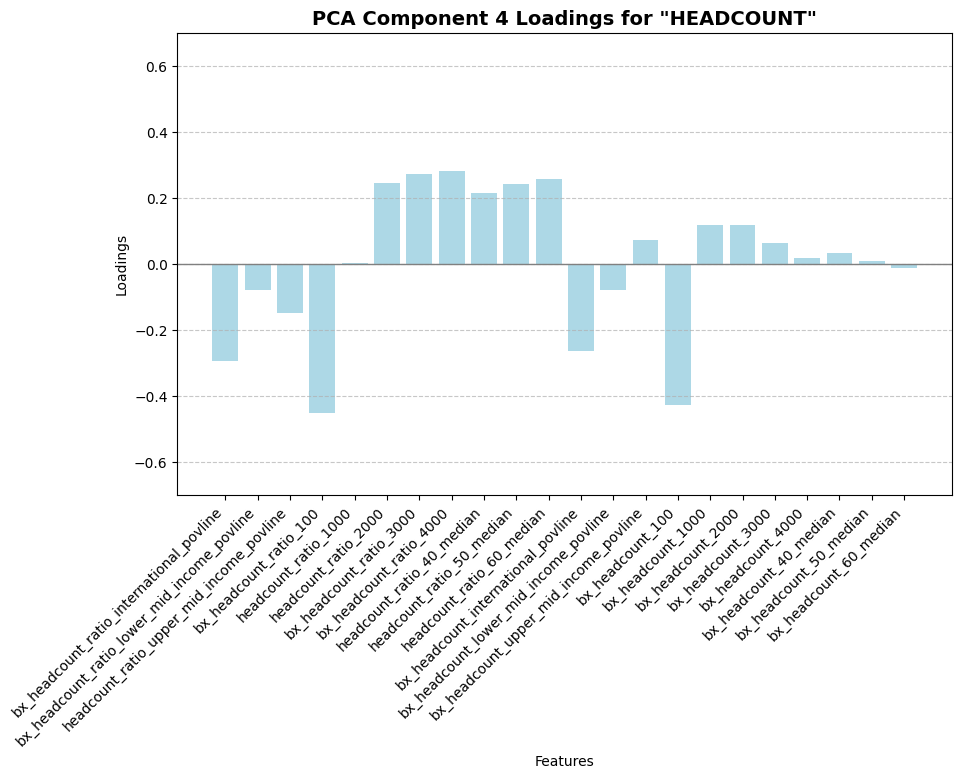

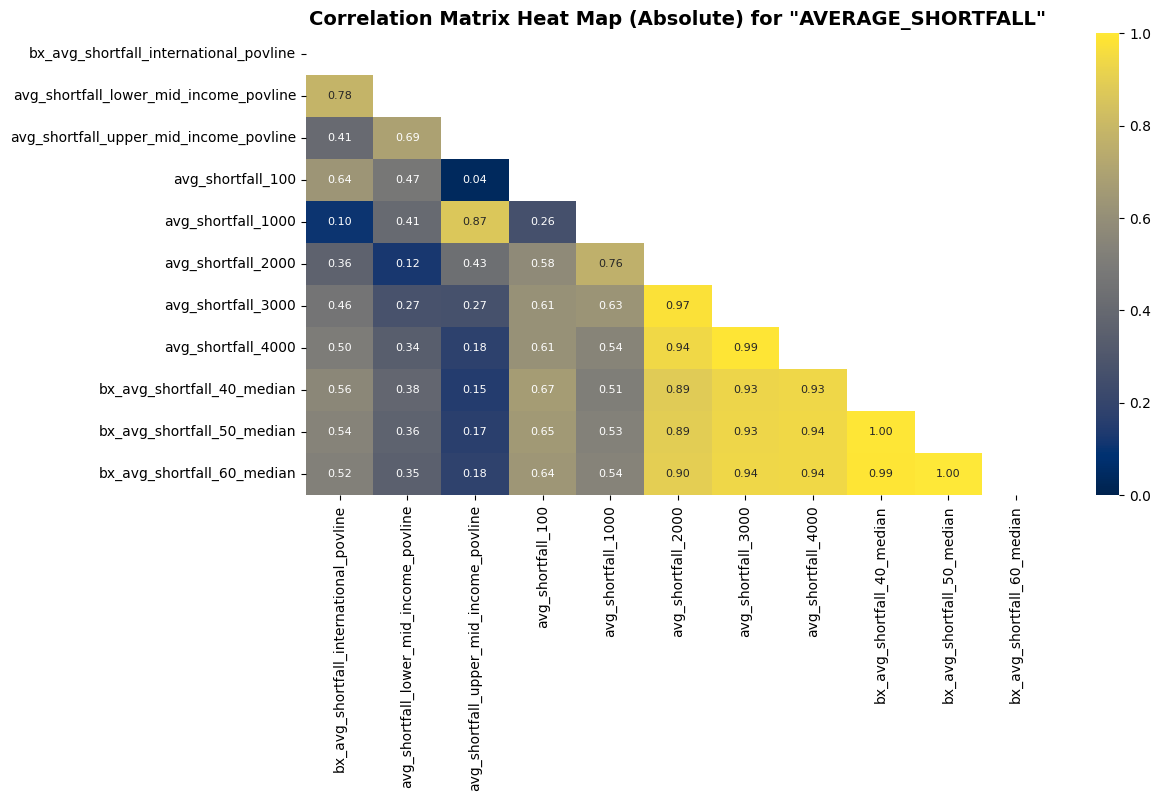

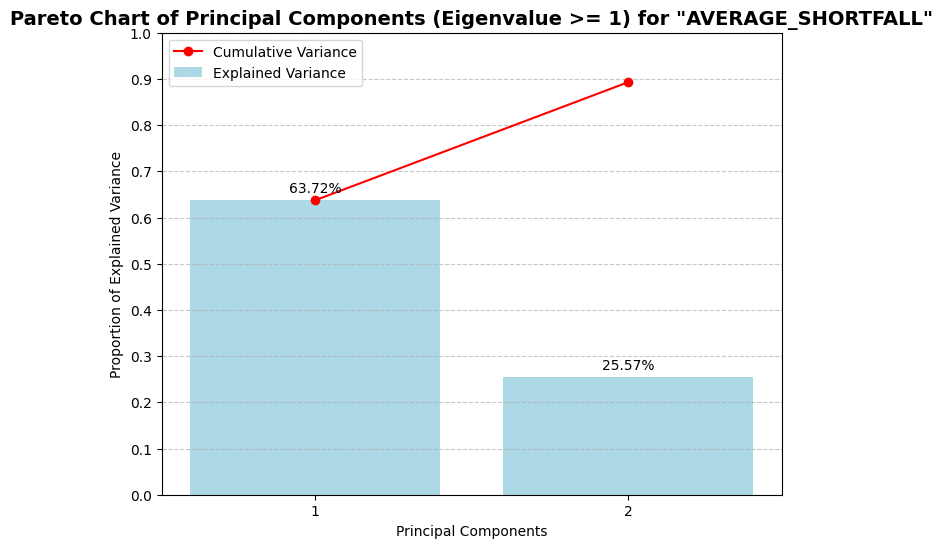

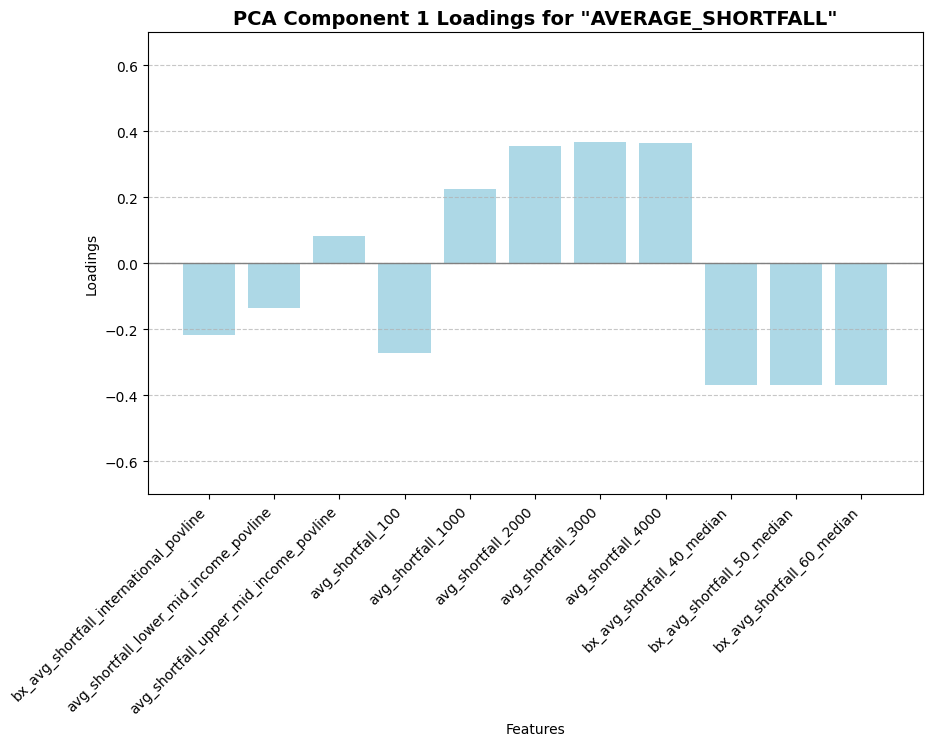

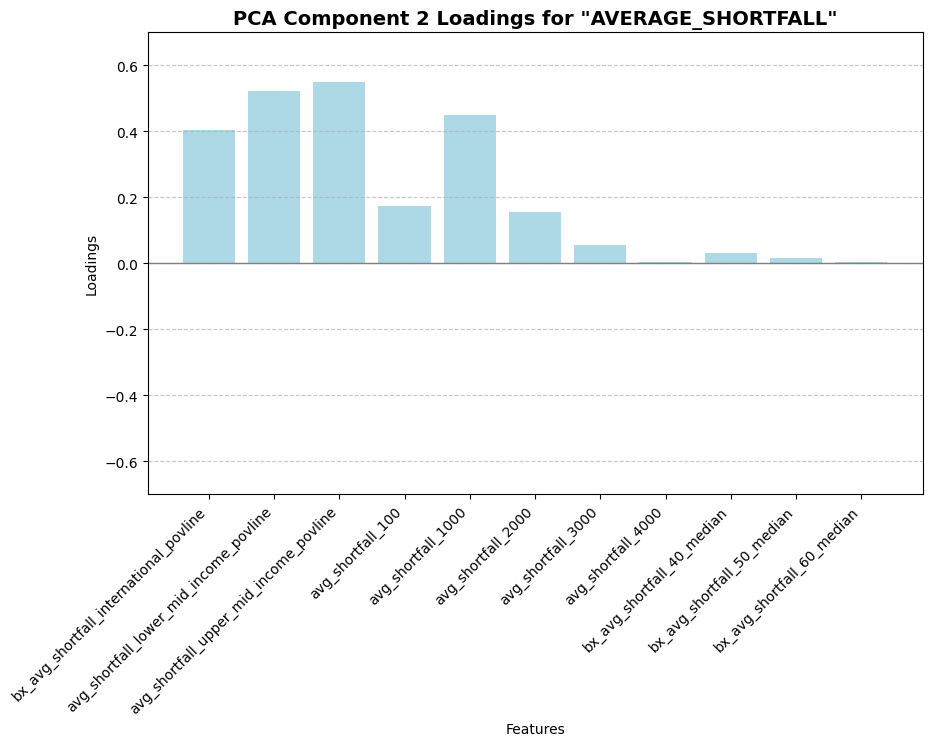

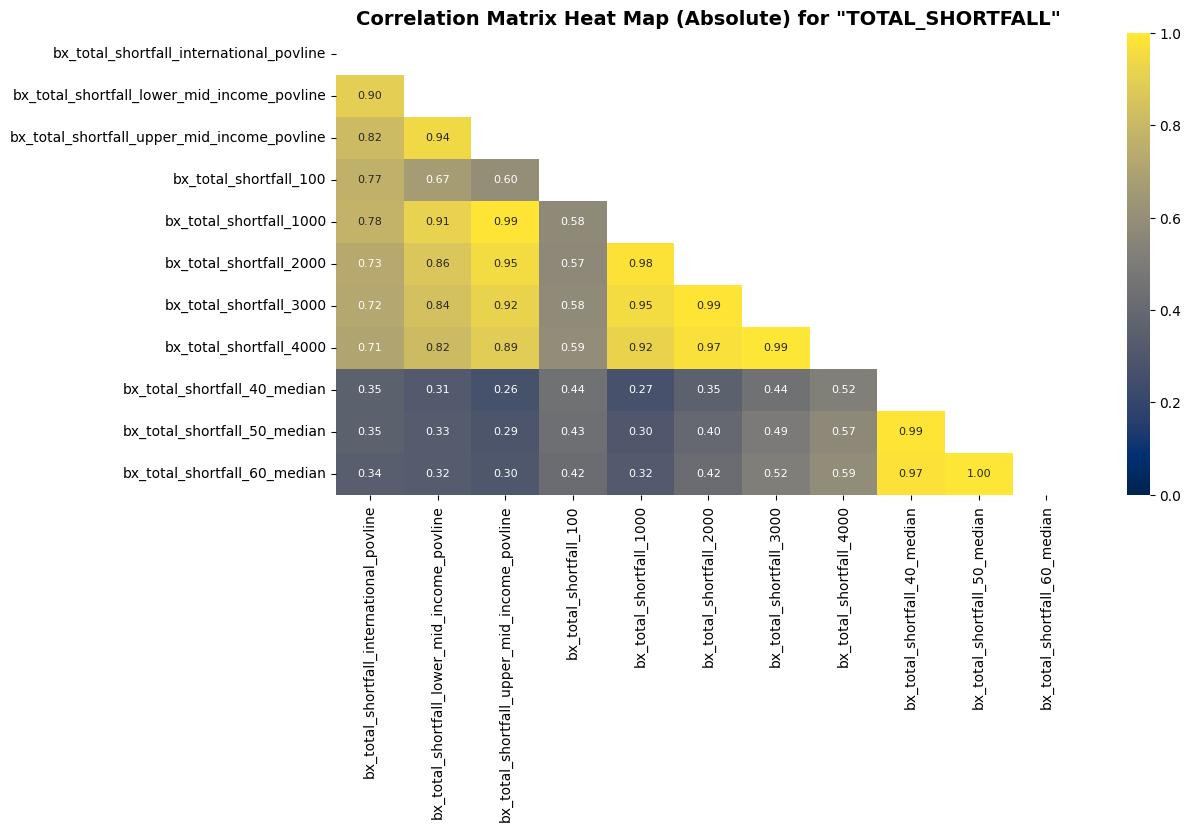

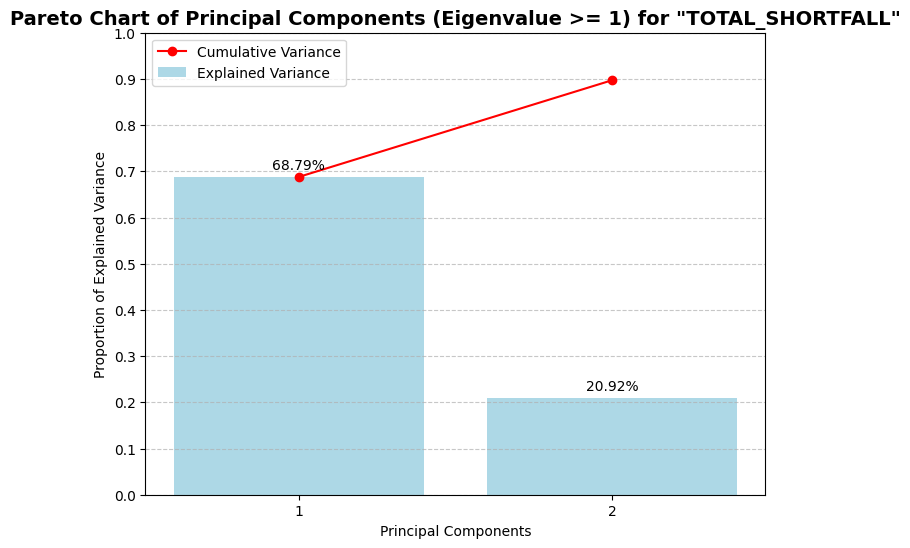

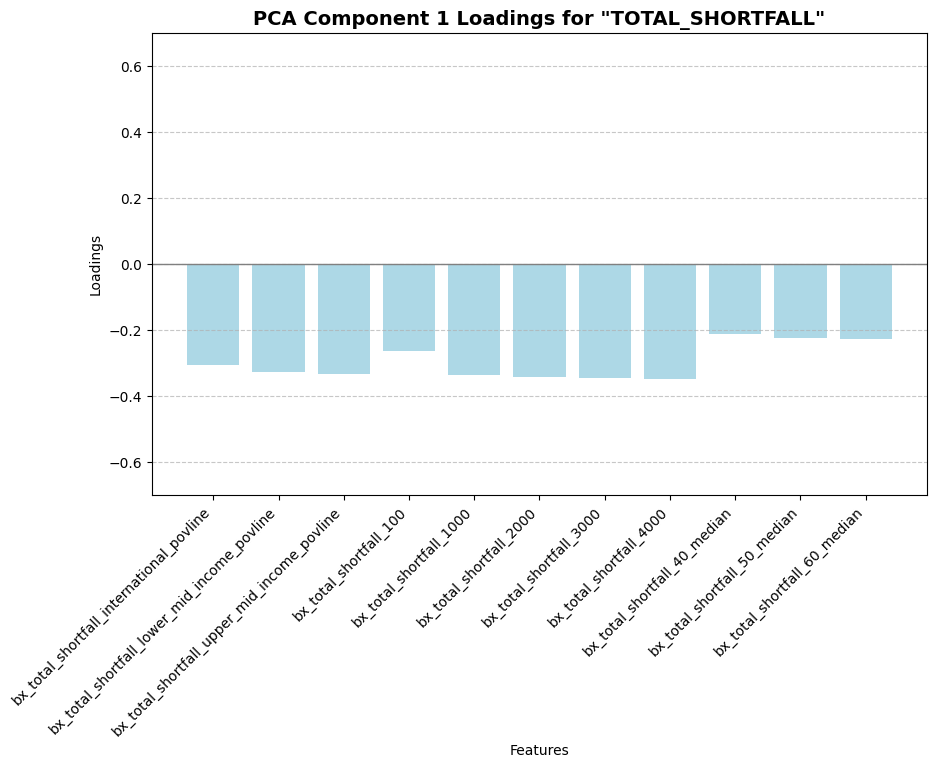

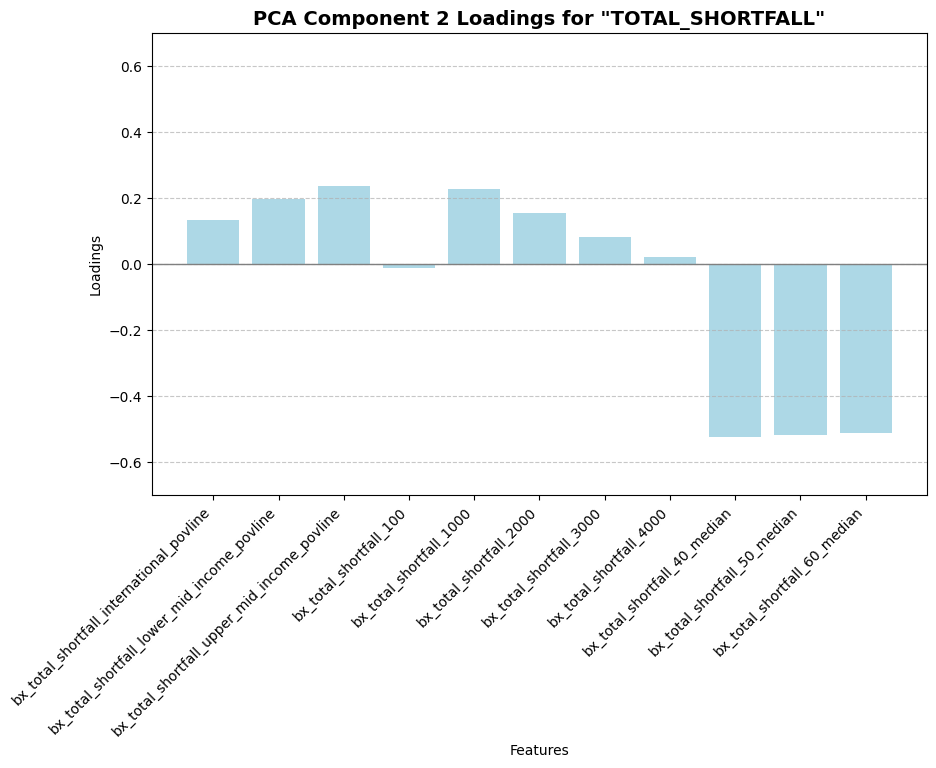

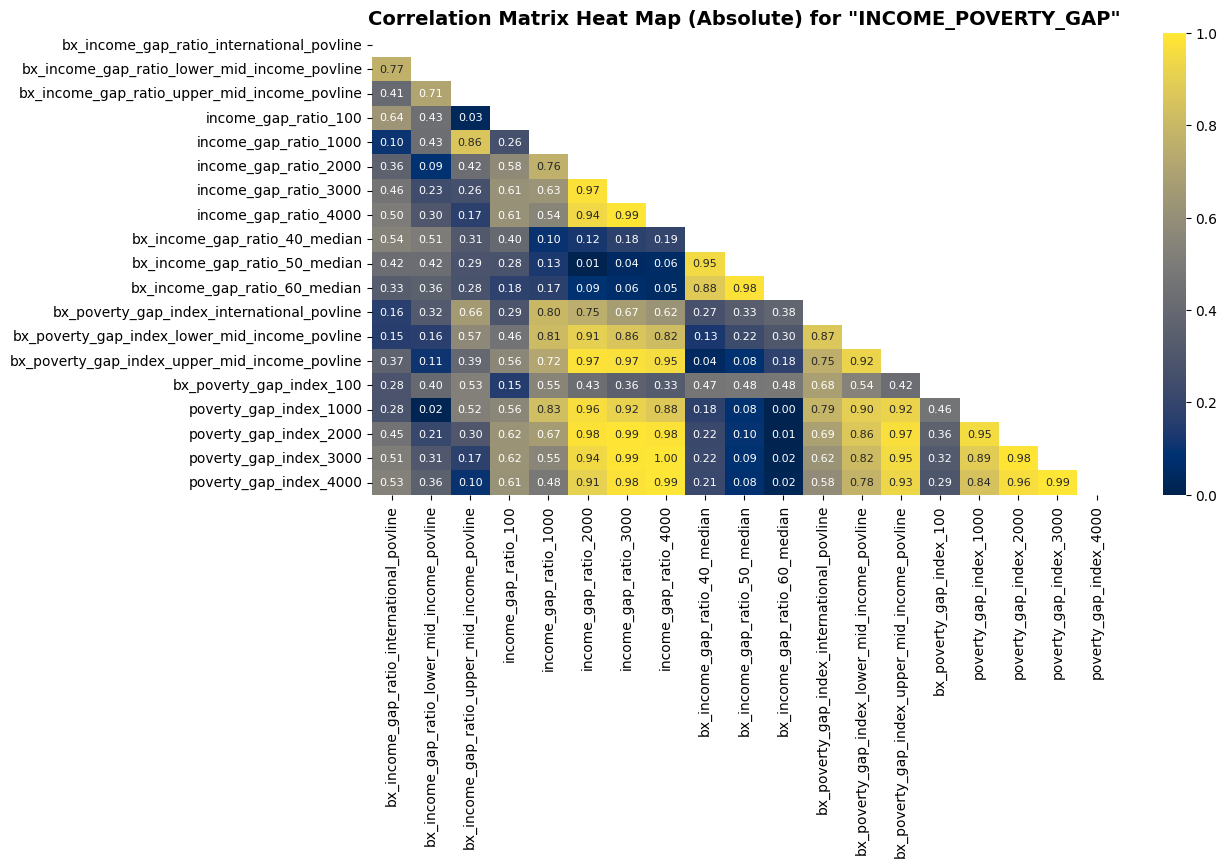

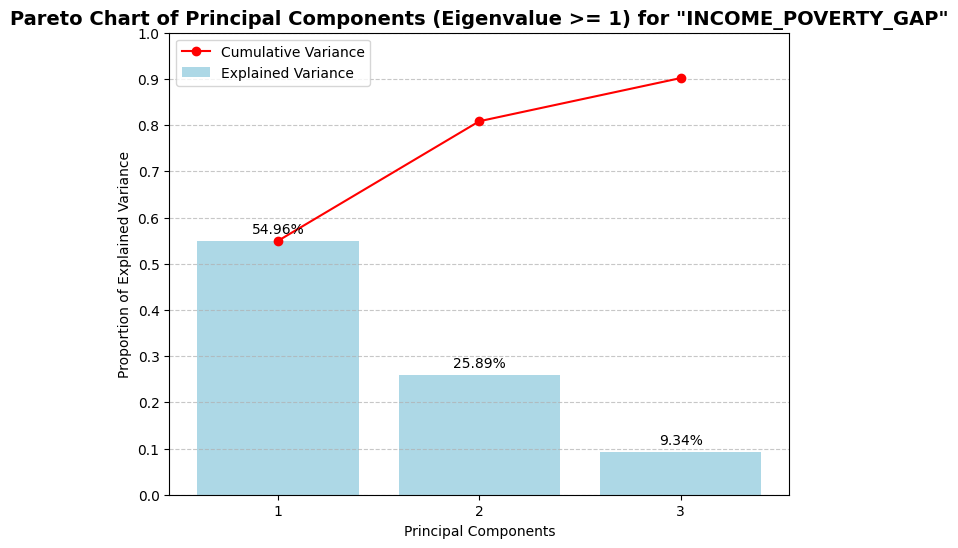

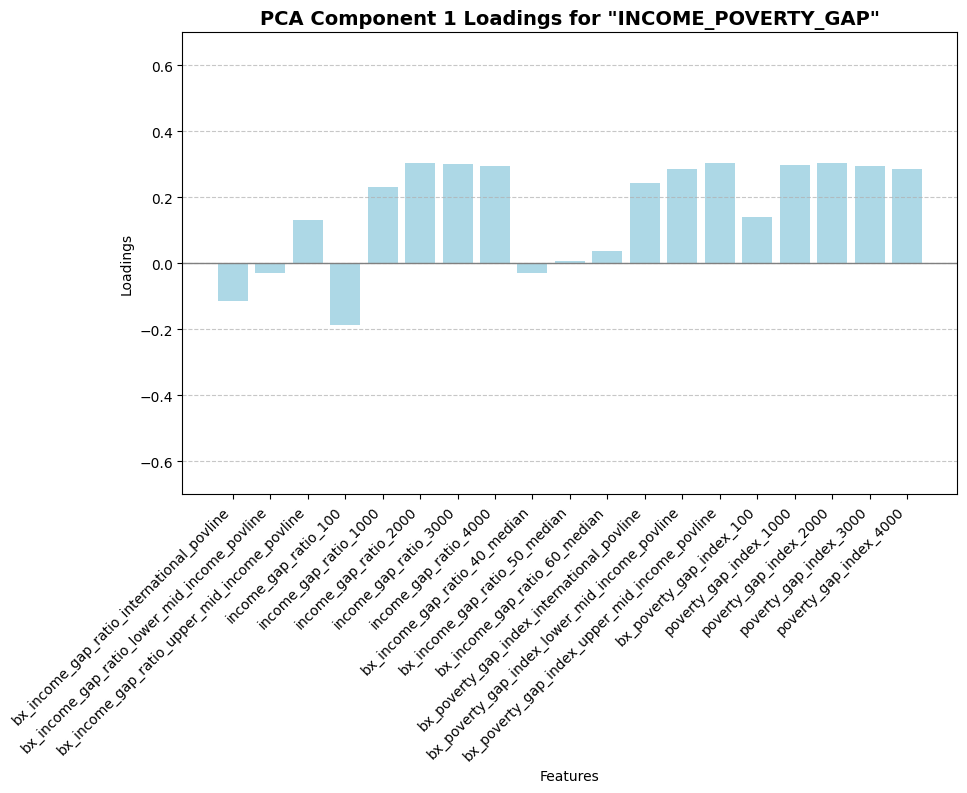

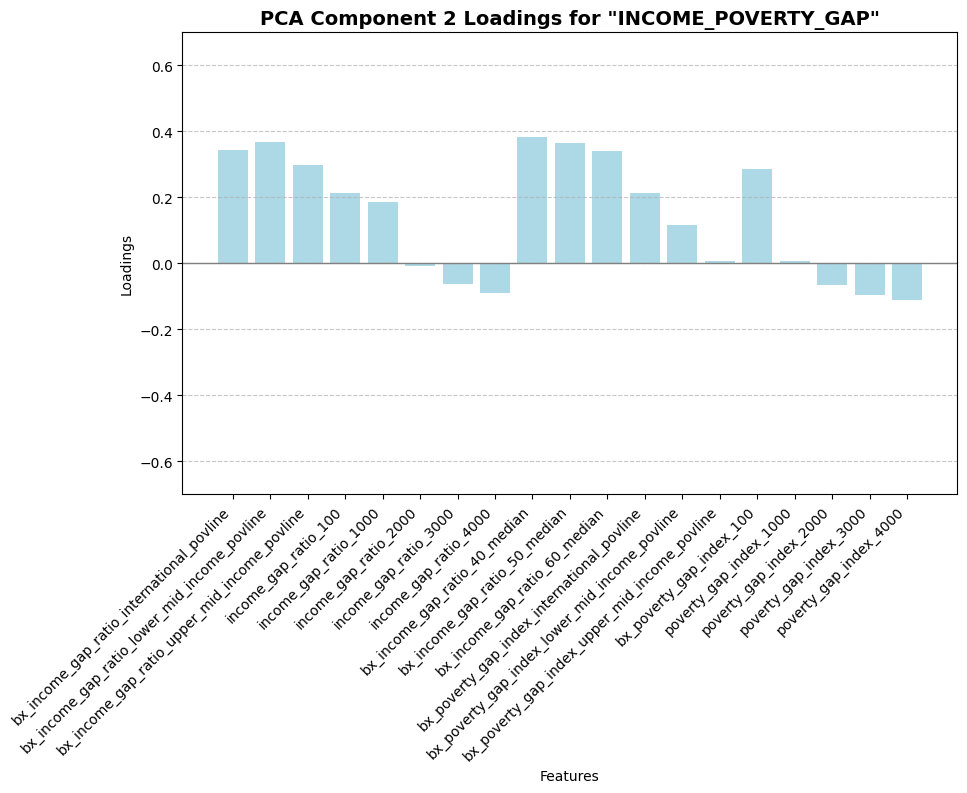

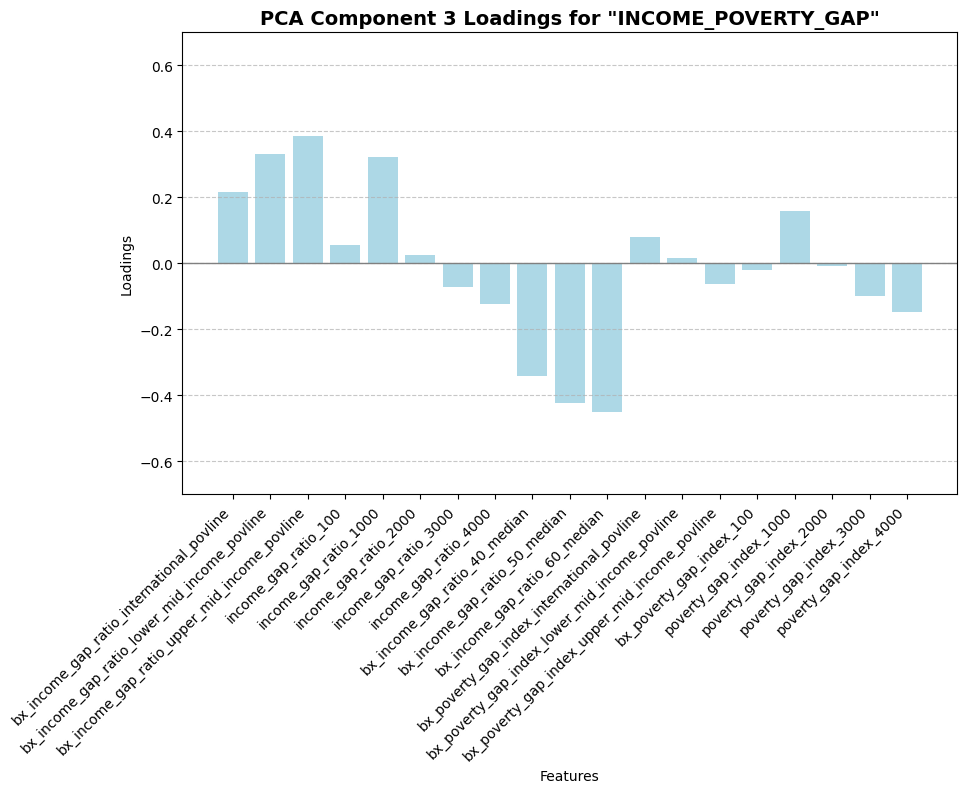

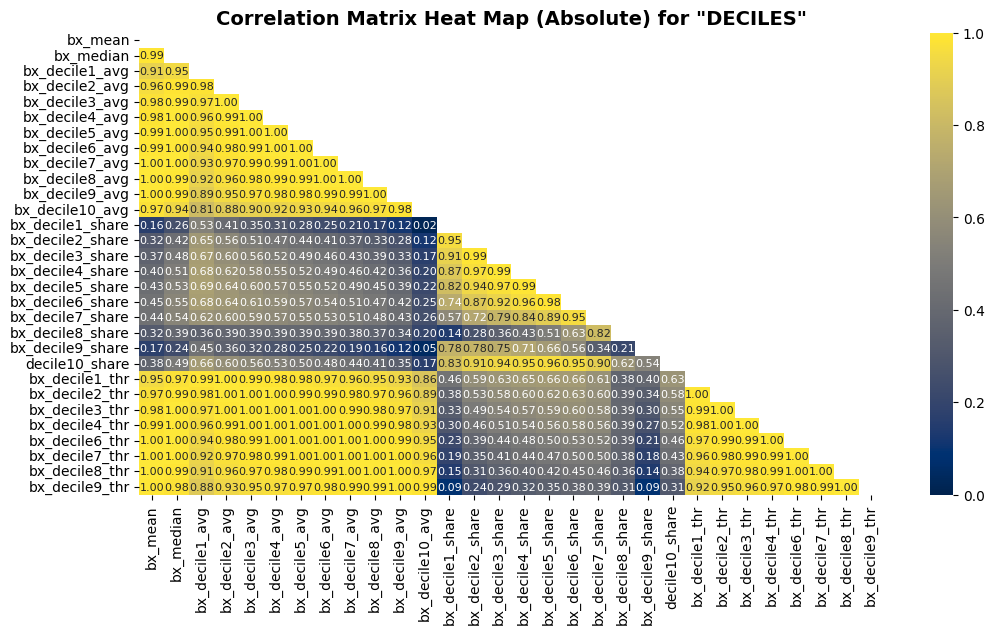

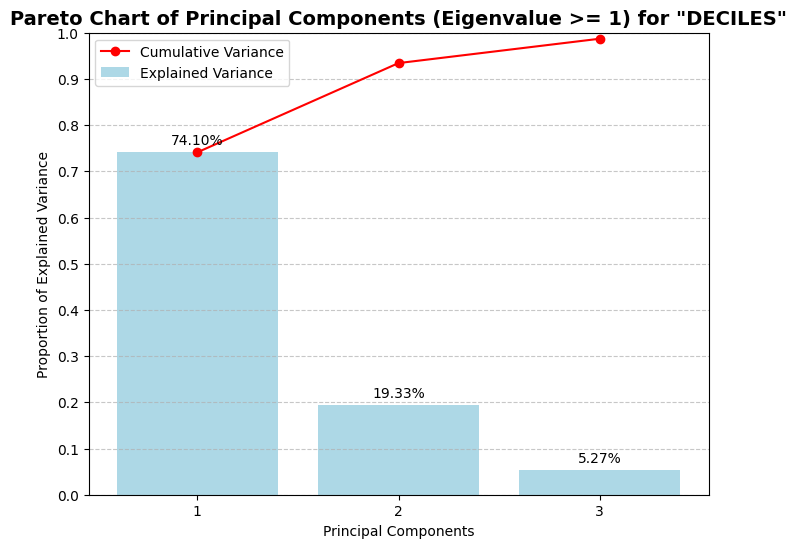

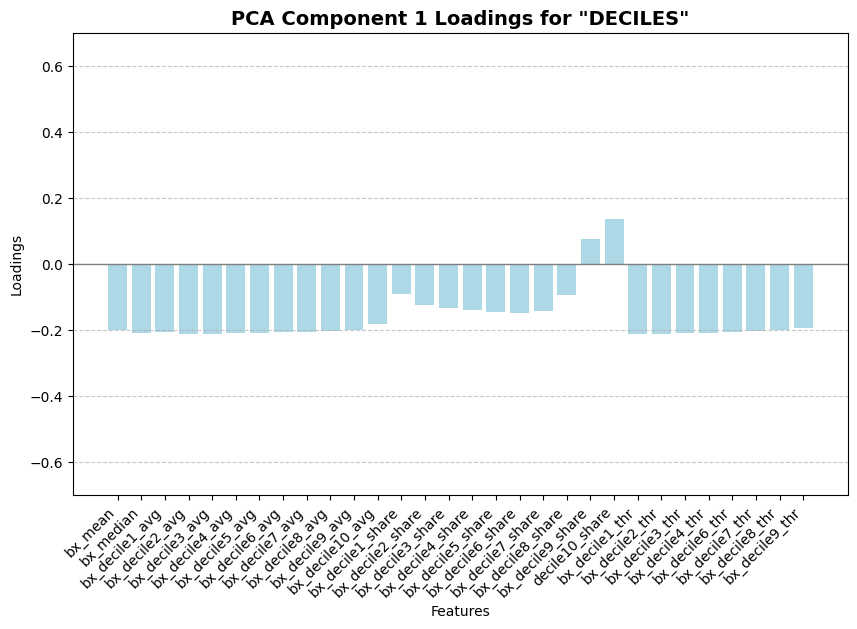

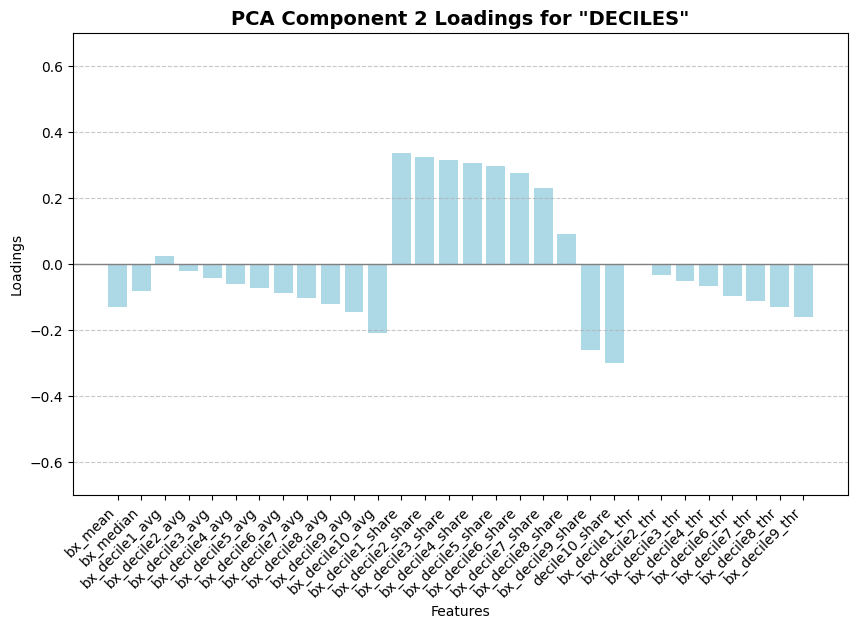

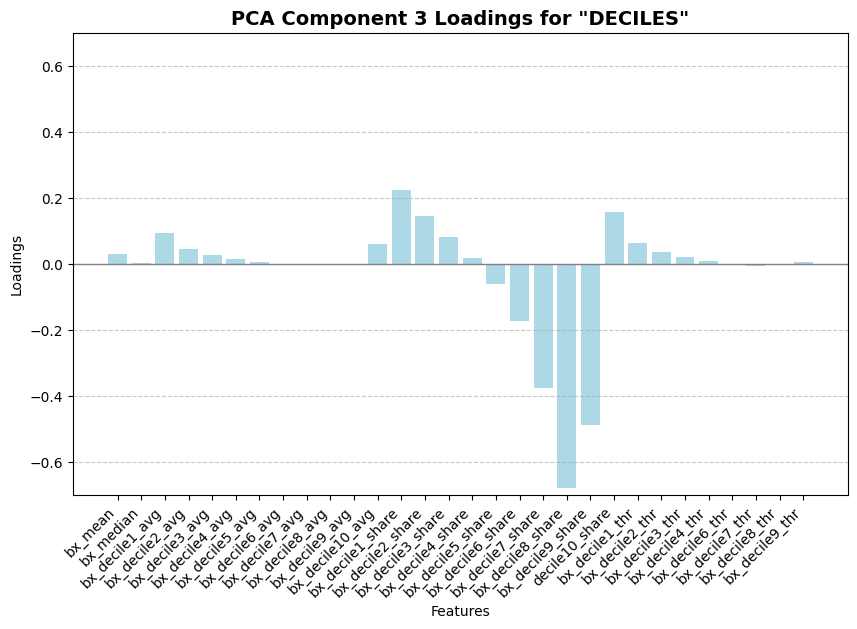

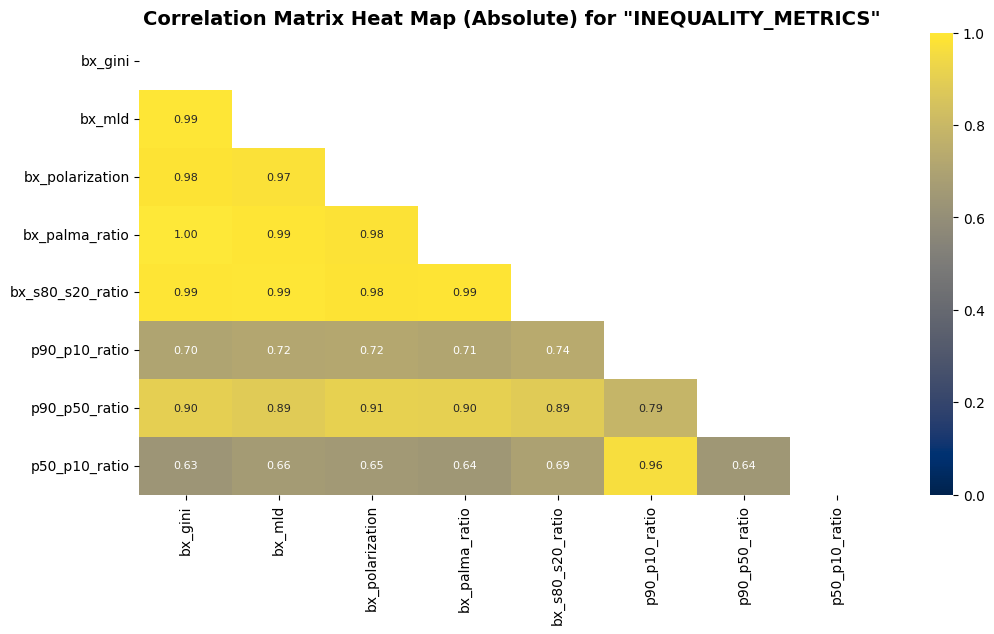

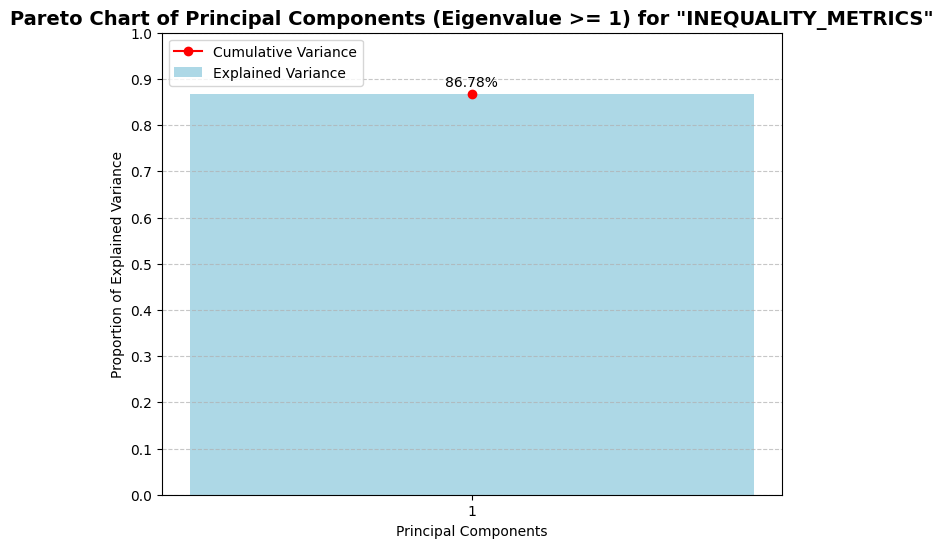

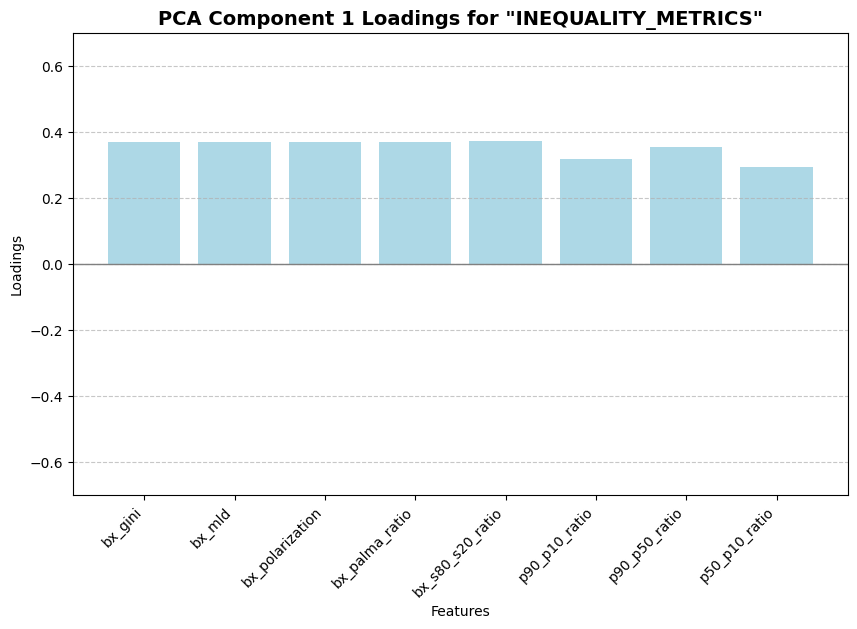

In [264]:
data['year'] = data['year'].astype('int')
dataset_PCA = data.iloc[:, :5]

for name, dataset in datasets.items():

    ## CORRELATION MATRIX HEAT MAP (VALORES ABSOLUTOS)
    corr_num = dataset.corr().abs()  # Toma el valor absoluto de la matriz de correlación
    mask = np.triu(np.ones_like(corr_num, dtype=bool))  # Máscara para ocultar la parte superior derecha duplicada

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_num, mask=mask, annot=True, fmt=".2f", cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)
    plt.title(f'Correlation Matrix Heat Map (Absolute) for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.show()

    ## PCA & PARETO CHART
    # Standardize using Z-score
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(dataset)

    pca = PCA()
    pca_data = pca.fit_transform(data_standardized)
    explained_variance = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_  # Extract eigenvalues

    # Select components with eigenvalue >= 1
    n_components = np.sum(eigenvalues >= 1)
    explained_variance_N = explained_variance[:n_components]
    cumulative_variance_N = np.cumsum(explained_variance_N)

    # Pareto Chart
    plt.figure(figsize=(8, 6))
    components = np.arange(1, n_components + 1)

    # Explained and cumulative variance
    plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
    plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

    plt.xlabel("Principal Components")
    plt.ylabel("Proportion of Explained Variance")
    plt.title(f'Pareto Chart of Principal Components (Eigenvalue >= 1) for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})


    # Add labels with the percentage variability
    for i in range(len(components)):
        plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)

    plt.xticks(components)
    plt.legend(loc='upper left', title_fontsize='medium', prop={'size': 10})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
    plt.ylim(0, 1)
    plt.show()

    ## LOADING PLOT FOR PCA COMPONENTS
    loadings = pca.components_[:n_components, :]  # Get the loadings for selected components
    features = dataset.columns

    for i in range(n_components):
        plt.figure(figsize=(10, 6))
        plt.bar(features, loadings[i], color='lightblue')
        plt.xlabel('Features')
        plt.ylabel('Loadings')
        plt.title(f'PCA Component {i+1} Loadings for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})
        plt.xticks(rotation=45, ha='right')
        plt.axhline(0, color='grey', lw=1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(-0.7, 0.7)
        plt.show()

    ## Select and store components based on eigenvalue >= 1
    pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components)]
    dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components], columns=pca_columns)
    dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)

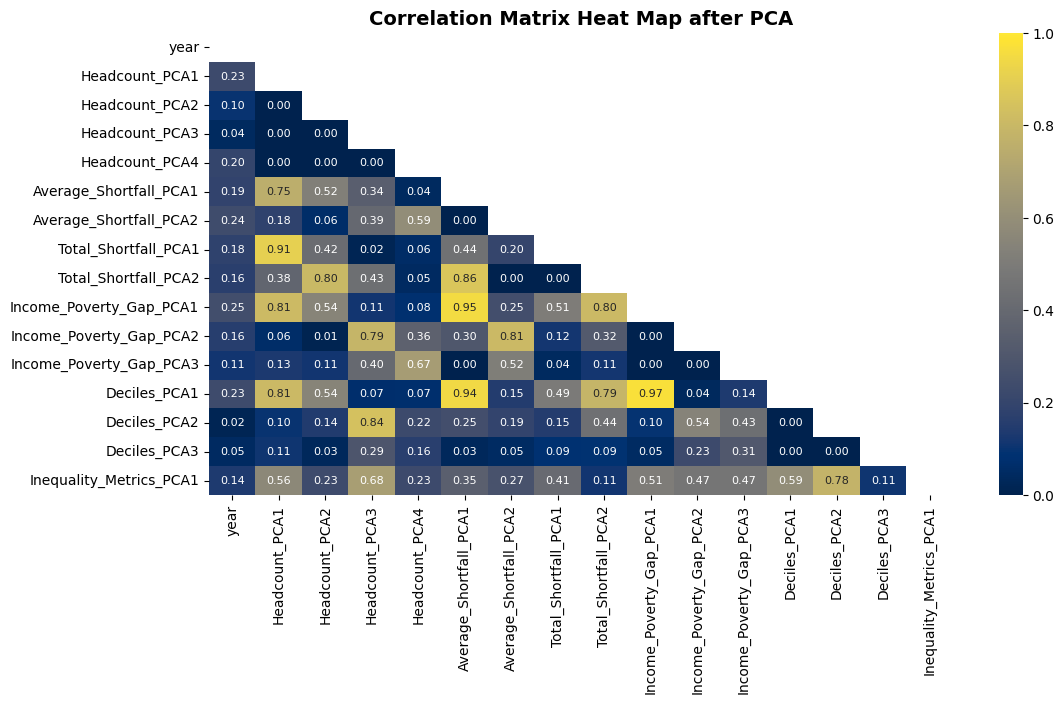

In [265]:
dataset_PCA
feat_names = dataset_PCA.columns
feat_num = [feat for feat in feat_names if feat not in feat_cat]

## CORRELATION MATRIX HEAT MAP
corr_num = dataset_PCA[feat_num].corr().abs()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_num, mask=mask, annot=True, fmt=".2f", cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)
plt.title(f'Correlation Matrix Heat Map after PCA', fontdict={'fontsize': 14, 'weight': 'bold'})
plt.show()

Una vez simplificado el conjunto de datos, completamos el dataset mediante información espacial:

In [266]:

world = gpd.read_file('world-administrative-boundaries.shp')
print(world.head())
world.drop(['iso3','status','region','iso_3166_1_','french_shor','continent'], axis= 1, inplace=True)
world.rename(columns={'name': 'country'}, inplace=True)
world.head()

   iso3                 status color_code                      name continent  \
0   MNP           US Territory        USA  Northern Mariana Islands   Oceania   
1  None  Sovereignty unsettled        RUS             Kuril Islands      Asia   
2   FRA           Member State        FRA                    France    Europe   
3   SRB           Member State        SRB                    Serbia    Europe   
4   URY           Member State        URY                   Uruguay  Americas   

            region iso_3166_1_               french_shor  \
0       Micronesia          MP  Northern Mariana Islands   
1     Eastern Asia        None             Kuril Islands   
2   Western Europe          FR                    France   
3  Southern Europe          RS                    Serbie   
4    South America          UY                   Uruguay   

                                            geometry  
0  MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...  
1  MULTIPOLYGON (((146.68274 43.70777, 146

color_code                   country  \
0        USA  Northern Mariana Islands   
1        RUS             Kuril Islands   
2        FRA                    France   
3        SRB                    Serbia   
4        URY                   Uruguay   

                                            geometry  
0  MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...  
1  MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...  
2  MULTIPOLYGON (((9.4475 42.68305, 9.45014 42.63...  
3  POLYGON ((20.26102 46.11485, 20.31403 46.06986...  
4  POLYGON ((-53.3743 -33.74067, -53.39917 -33.75...

In [267]:
# Crea un diccionario con las correspondencias manuales entre los nombres de países
country_name_mapping = {
    'bosnia & herzegovina': 'bosnia and herzegovina',
    'midway is.': 'midway islands',
    'libyan arab jamahiriya': 'libya',
    'moldova, republic of': 'moldova',
    'micronesia (federated states of)': 'micronesia (country)',
    'united states of america': 'united states',
    'united republic of tanzania': 'tanzania',
    "democratic people's republic of korea": 'north korea',
    'iran (islamic republic of)': 'iran',
    'czech republic': 'czechia',
    'u.k. of great britain and northern ireland': 'united kingdom',
    'timor-leste': 'timor',
    "lao people's democratic republic": 'laos',
    'swaziland': 'eswatini',
    'syrian arab republic': 'syria',
    'russian federation': 'russia',
    'the former yugoslav republic of macedonia': 'north macedonia',
    "côte d'ivoire": "cote d'ivoire",
    'democratic republic of the congo': 'democratic republic of congo',   
    #  : 'kosovo'
}

# Función para normalizar los nombres de los países
def normalize_country_names(df, column_name, mapping):
    # Convertir todos los nombres a minúsculas y eliminar espacios extra
    df[column_name] = df[column_name].str.lower().str.strip()
    # Reemplazar los nombres según el diccionario de mapeo
    df[column_name] = df[column_name].replace(mapping)
    return df

In [268]:
# Normaliza los nombres de los países en ambos datasets
dataset_PCA = normalize_country_names(dataset_PCA, 'country', country_name_mapping)
world = normalize_country_names(world, 'country', country_name_mapping)

# Fusiona los datasets basándose en el nombre del país
gdf = pd.merge(dataset_PCA, world, on='country', how='inner')

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

print("Dataset fusionado:")
print(gdf.shape)
gdf.head()

Dataset fusionado:
(1990, 22)


country continent  year welfare_type  survey_comparability  Headcount_PCA1  \
0  albania    Europe  1996  consumption                   0.0        1.312920   
1  albania    Europe  2002  consumption                   1.0        1.096722   
2  albania    Europe  2005  consumption                   1.0        0.868004   
3  albania    Europe  2008  consumption                   1.0        1.591276   
4  albania    Europe  2012  consumption                   1.0        1.809728   

   Headcount_PCA2  Headcount_PCA3  Headcount_PCA4  Average_Shortfall_PCA1  \
0        1.899592       -2.674772        1.320097                2.381453   
1        2.000267       -2.443924        1.288519                1.955166   
2        2.006400       -1.623885        0.225115                1.563704   
3        1.854049       -2.189126        0.217772                1.404511   
4        1.650394       -2.535354        1.700450                1.531978   

   ...  Total_Shortfall_PCA2  Income_Poverty_Gap_PCA1  \
0  ...              1.863841                 1.205129   
1  ...              1.813447                 1.263087   
2  ...              1.441950                 0.821046   
3  ...              1.626874                 0.194479   
4  ...              1.470234                 0.482246   

   Income_Poverty_Gap_PCA2  Income_Poverty_Gap_PCA3  Deciles_PCA1  \
0                -4.224288                 0.143895      0.706710   
1                -3.124973                 0.101251      1.689018   
2                -2.905300                -0.348602      0.908215   
3                -3.688711                -0.096773      0.525598   
4                -3.298559                -0.503139      0.431850   

   Deciles_PCA2  Deciles_PCA3  Inequality_Metrics_PCA1  color_code  \
0      4.320062     -1.160221                -3.126536         ALB   
1      2.548803      0.051216                -1.640496         ALB   
2      2.827755     -0.214615                -2.009331         ALB   
3      2.852396      0.447791                -2.292949         ALB   
4      3.288979     -0.562283                -2.515764         ALB   

                                            geometry  
0  POLYGON ((20.07142 42.56091, 20.10208 42.53347...  
1  POLYGON ((20.07142 42.56091, 20.10208 42.53347...  
2  POLYGON ((20.07142 42.56091, 20.10208 42.53347...  
3  POLYGON ((20.07142 42.56091, 20.10208 42.53347...  
4  POLYGON ((20.07142 42.56091, 20.10208 42.53347...  

[5 rows x 22 columns]

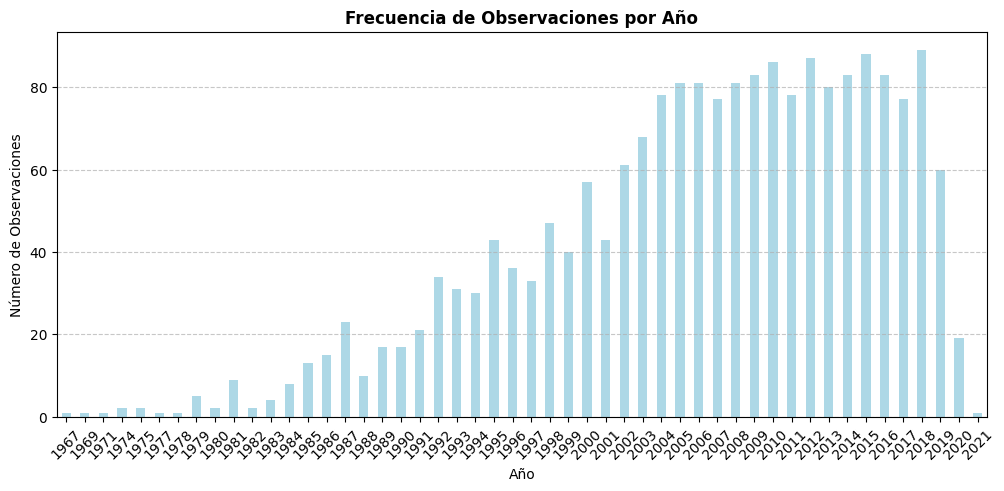

In [269]:
# Contar las observaciones por año
year_counts = gdf['year'].value_counts().sort_index()

# Graficar histograma
plt.figure(figsize=(12, 5))
year_counts.plot(kind='bar',color='lightblue')
plt.title('Frecuencia de Observaciones por Año',fontdict={'fontsize': 12, 'weight': 'bold'})
plt.xlabel('Año')
plt.ylabel('Número de Observaciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 5. Análisis cluster <a class="anchor" id="seccion_5"></a>

Clustering con k-means. Buscamos el nº de clusters óptimos así como las variables más discriminativas por medio de Silhouette Score y Calinski-Harabasz Index. 
- **Silhouette Score**: mide la cohesión dentro de un cluster en comparación con otros clusters (separación). Valores entre -1 y 1 (1 perfectamente asignado, 0 en el borde entre clusters, -1 asignado al cluster incorrecto). Funciona bien para clusters bien separados.
- **Calinski-Harabasz Index**: evalúa el clustering mediante un cociente CH = varianza intercluster / varianza intracluster, por lo que valores más altos indican mejor separación y menor dispersión interna. Es más eficiente computacionalmente

In [280]:
# Prepare environment
var1_clustering = 'Inequality_Metrics_PCA1'
# var1_clustering = 'Deciles_PCA1'
# var1_clustering = 'Total_Shortfall_PCA1'
var2_clustering = 'Average_Shortfall_PCA1'
# var1_clustering = 'Average_Shortfall_PCA2'
# var1_clustering = 'Headcount_PCA1'
# var2_clustering = 'Headcount_PCA2'

year = 2017
gdf_year = gdf[gdf['year']==year]
X_gdf = gdf_year.iloc[:, 5:20]

# Calculate the global min and max for the variables
var1_min, var1_max = X_gdf[var1_clustering].min(), X[var1_clustering].max()
var2_min, var2_max = X_gdf[var2_clustering].min(), X[var2_clustering].max()

In [281]:
X = X_gdf[[var1_clustering, var2_clustering]]

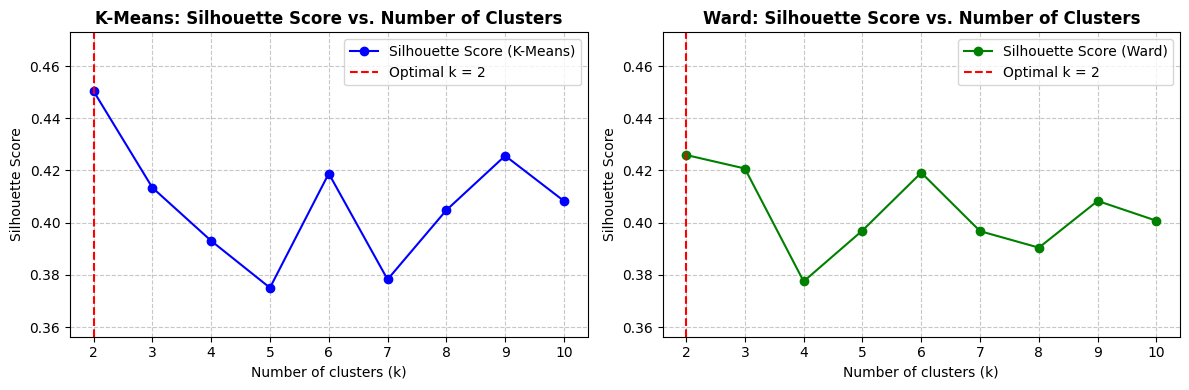

In [297]:
# Range of cluster numbers
k_values = range(2, 11)
silhouette_scores_kmeans = []
silhouette_scores_ward = []

# Calculate silhouette scores for both methods
for k in k_values:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=9)
    labels_kmeans = kmeans.fit_predict(X)
    silhouette_scores_kmeans.append(silhouette_score(X, labels_kmeans))
    
    # Ward Hierarchical Clustering
    ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_ward = ward.fit_predict(X)
    silhouette_scores_ward.append(silhouette_score(X, labels_ward))

# Find optimal k for both methods
optimal_k_kmeans = k_values[np.argmax(silhouette_scores_kmeans)]
optimal_k_ward = k_values[np.argmax(silhouette_scores_ward)]

# Determine global Y-axis limits
y_min = min(min(silhouette_scores_kmeans), min(silhouette_scores_ward)) * 0.95
y_max = max(max(silhouette_scores_kmeans), max(silhouette_scores_ward)) * 1.05 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# K-Means plot
axes[0].plot(k_values, silhouette_scores_kmeans, marker='o', linestyle='-', color='blue', label='Silhouette Score (K-Means)')
axes[0].axvline(optimal_k_kmeans, color='red', linestyle='--', label=f'Optimal k = {optimal_k_kmeans}')
axes[0].set_title("K-Means: Silhouette Score vs. Number of Clusters", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_ylim(y_min, y_max)  # Set common Y limits
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ward plot
axes[1].plot(k_values, silhouette_scores_ward, marker='o', linestyle='-', color='green', label='Silhouette Score (Ward)')
axes[1].axvline(optimal_k_ward, color='red', linestyle='--', label=f'Optimal k = {optimal_k_ward}')
axes[1].set_title("Ward: Silhouette Score vs. Number of Clusters", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_ylim(y_min, y_max)  # Set common Y limits
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


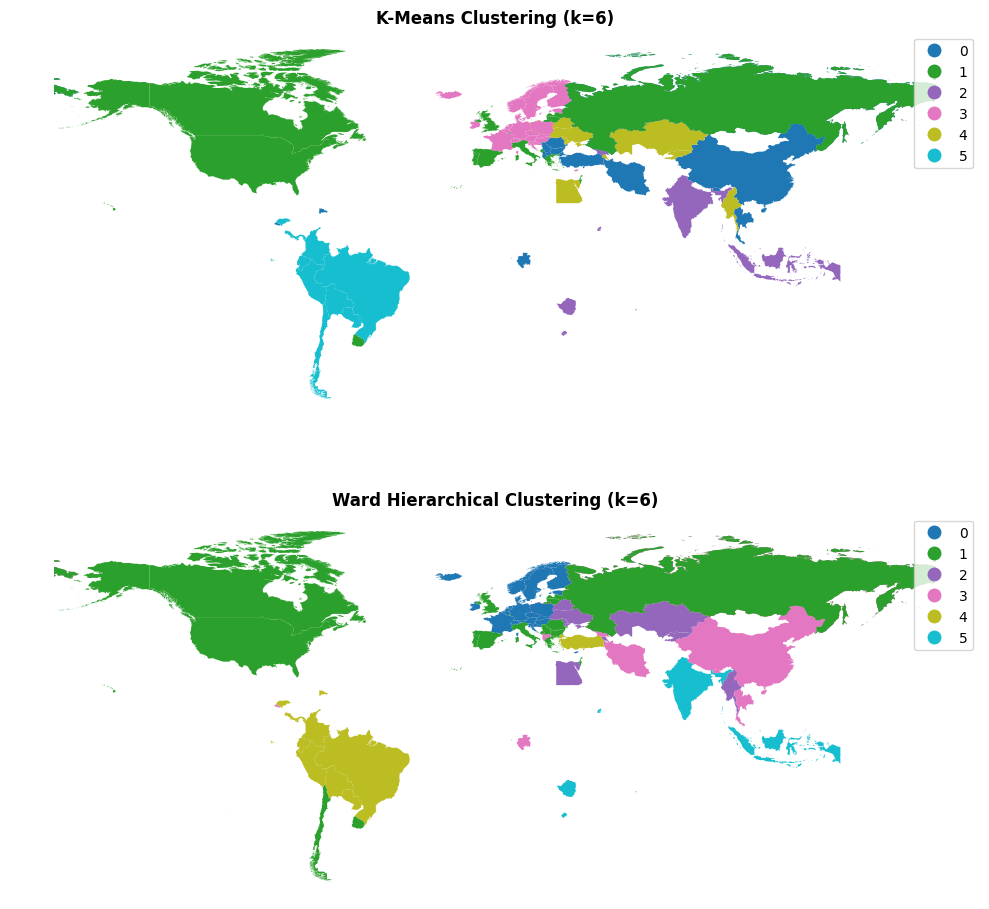

In [290]:
k = 6

# K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf_year['kmeans_cluster'] = kmeans.fit_predict(X_gdf)

# Ward Hierarchical Clustering
ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
gdf_year['ward_cluster'] = ward.fit_predict(X_gdf)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
categorical_cmap = 'tab10' 

# K-Means Plot
gdf_year.plot(column='kmeans_cluster', cmap=categorical_cmap, legend=True, ax=axes[0], categorical=True)
axes[0].set_title(f'K-Means Clustering (k={k})', fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0].axis('off')

# Ward Hierarchical Plot
gdf_year.plot(column='ward_cluster', cmap=categorical_cmap, legend=True, ax=axes[1], categorical=True)
axes[1].set_title(f'Ward Hierarchical Clustering (k={k})', fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1].axis('off')

plt.tight_layout()
plt.show()

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


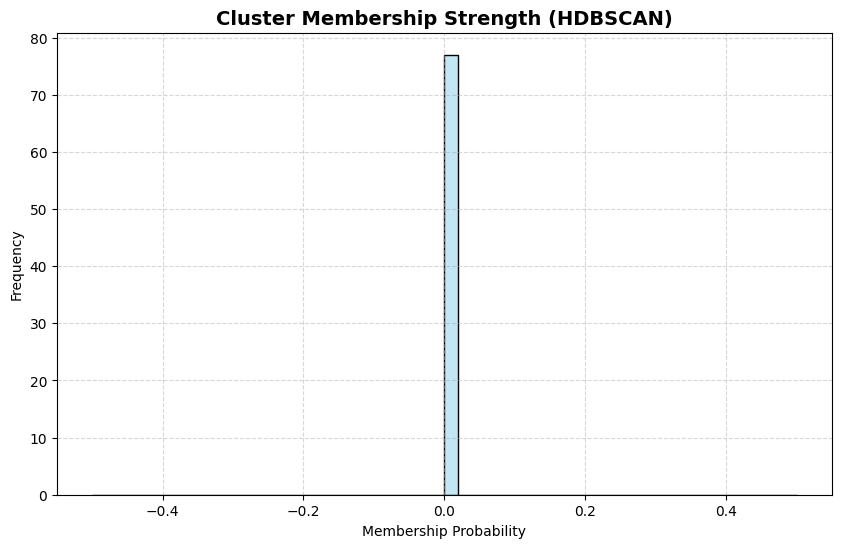

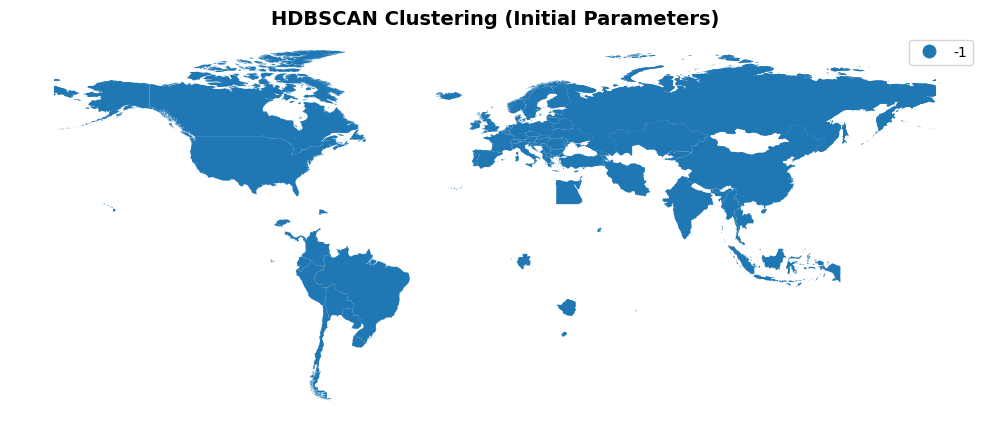

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


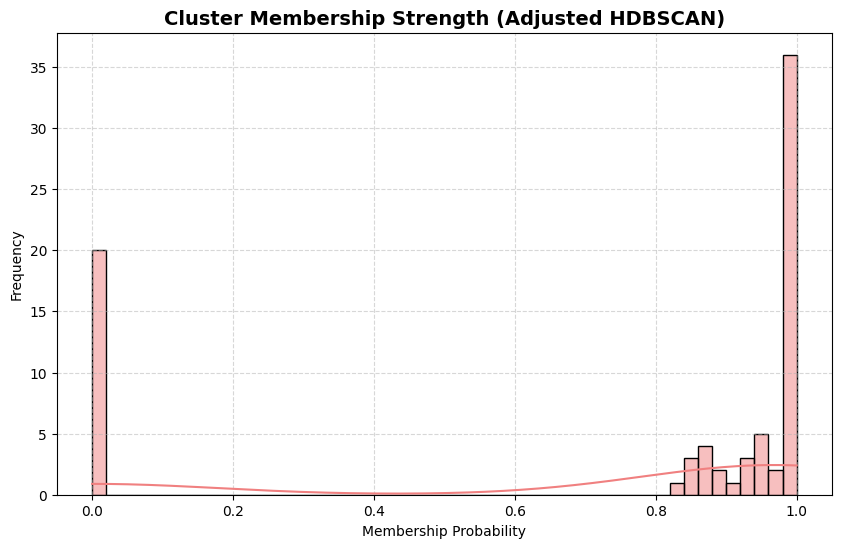

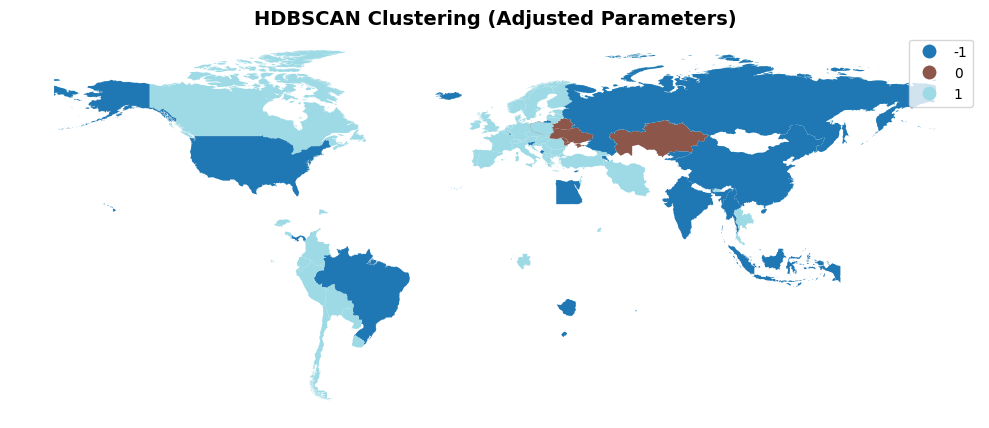

In [307]:
# HDBSCAN Inicial (Diagnóstico)
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean', cluster_selection_method='eom')
gdf_year['hdbscan_cluster'] = hdbscan_cluster.fit_predict(X_gdf)

# Diagnóstico: Histograma de Membership Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(hdbscan_cluster.probabilities_, bins=50, kde=True, color='skyblue')
plt.title('Cluster Membership Strength (HDBSCAN)', fontsize=14, weight='bold')
plt.xlabel('Membership Probability')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Visualizar el clustering inicial
fig, ax = plt.subplots(figsize=(10, 8))
gdf_year.plot(column='hdbscan_cluster', cmap='tab20', legend=True, ax=ax, categorical=True)
ax.set_title('HDBSCAN Clustering (Initial Parameters)', fontdict={'fontsize': 14, 'weight': 'bold'})
ax.axis('off')
plt.tight_layout()
plt.show()

# Ajuste de Parámetros de HDBSCAN
hdbscan_cluster_adjusted = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean', cluster_selection_method='eom')
gdf_year['hdbscan_cluster_adjusted'] = hdbscan_cluster_adjusted.fit_predict(X_gdf)

# Diagnóstico después del ajuste
plt.figure(figsize=(10, 6))
sns.histplot(hdbscan_cluster_adjusted.probabilities_, bins=50, kde=True, color='lightcoral')
plt.title('Cluster Membership Strength (Adjusted HDBSCAN)', fontsize=14, weight='bold')
plt.xlabel('Membership Probability')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Visualizar clustering ajustado
fig, ax = plt.subplots(figsize=(10, 8))
gdf_year.plot(column='hdbscan_cluster_adjusted', cmap='tab20', legend=True, ax=ax, categorical=True)
ax.set_title('HDBSCAN Clustering (Adjusted Parameters)', fontdict={'fontsize': 14, 'weight': 'bold'})
ax.axis('off')
plt.tight_layout()
plt.show()


### 6. Análisis geoestadístico <a class="anchor" id="seccion_6"></a>


### Referencias <a class="anchor" id="seccion_7"></a>


1. https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset/data?select=pip_codebook.csv 
2. https://geographicdata.science/book/intro.html 
3.

&copy; 2024 Carlos de Manuel, Hugo Mugüerza & Manu Callejo - Universitat Politècnica de València 2024
